In [1]:
import pandas as pd
import numpy as np

import source.utility as ut
import source.transf_univ as df_p
import source.report as rp
from source.validate import random_split, yearly_split

from sklearn.model_selection import KFold
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import log_loss, mean_absolute_error

from sklearn.linear_model import Lasso, Ridge, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('max_columns', 300)

kfolds = KFold(n_splits=5, shuffle=True, random_state=345)

In [2]:
df = pd.read_csv('data/processed_men/training_data.csv')

df.head()

,Season,DayNum,Team1,Team2,target,target_points,T1_Loc,T2_Loc,ID,T1_Ast,T1_Ast_advantage,T1_Ast_diff,T1_Away,T1_Blk,T1_Blk_advantage,T1_Blk_diff,T1_DR,T1_DR_advantage,T1_DR_diff,T1_DR_opportunity,T1_DR_opportunity_advantage,T1_DR_opportunity_diff,T1_FGA,T1_FGA2,T1_FGA2_advantage,T1_FGA2_diff,T1_FGA3,T1_FGA3_advantage,T1_FGA3_diff,T1_FGA_advantage,T1_FGA_diff,T1_FGM,T1_FGM2,T1_FGM2_advantage,T1_FGM2_diff,T1_FGM3,T1_FGM3_advantage,T1_FGM3_diff,T1_FGM_advantage,T1_FGM_diff,T1_FGM_no_ast,T1_FGM_no_ast_advantage,T1_FGM_no_ast_diff,T1_FTA,T1_FTA_advantage,T1_FTA_diff,T1_FTM,T1_FTM_advantage,T1_FTM_diff,T1_N_wins,T1_OR,T1_OR_advantage,T1_OR_diff,T1_OR_opportunity,T1_OR_opportunity_advantage,T1_OR_opportunity_diff,T1_OT_win,T1_PF,T1_PF_advantage,T1_PF_diff,T1_Score,T1_Score_advantage,T1_Score_diff,T1_Stl,T1_Stl_advantage,T1_Stl_diff,T1_TO,T1_TO_advantage,T1_TO_diff,T1_TO_perposs,T1_TO_perposs_advantage,T1_TO_perposs_diff,T1_Tot_Reb,T1_Tot_Reb_advantage,T1_Tot_Reb_diff,T1_True_shooting_perc_advantage,T1_True_shooting_perc_diff,T1_def_rating,T1_def_rating_advantage,T1_def_rating_diff,T1_impact,T1_impact_advantage,T1_impact_diff,T1_off_rating,T1_off_rating_advantage,T1_off_rating_diff,T1_opp_FGA,T1_opp_FTA,T1_opp_possessions,T1_opp_score,T1_opp_shtg_opportunity,T1_possessions,T1_possessions_advantage,T1_possessions_diff,T1_shtg_opportunity,T1_shtg_opportunity_advantage,T1_shtg_opportunity_diff,T1_top_team,T1_upset,T1_FGM_perc,T1_FGM2_perc,T1_FGM3_perc,T1_FT_perc,T1_FGM_no_ast_perc,T1_True_shooting_perc,T1_Opp_True_shooting_perc,T1_OT_win_perc,T1_Seed,T1_Rank,T2_Ast,T2_Ast_advantage,T2_Ast_diff,T2_Away,T2_Blk,T2_Blk_advantage,T2_Blk_diff,T2_DR,T2_DR_advantage,T2_DR_diff,T2_DR_opportunity,T2_DR_opportunity_advantage,T2_DR_opportunity_diff,T2_FGA,T2_FGA2,T2_FGA2_advantage,T2_FGA2_diff,T2_FGA3,T2_FGA3_advantage,T2_FGA3_diff,T2_FGA_advantage,T2_FGA_diff,T2_FGM,T2_FGM2,T2_FGM2_advantage,T2_FGM2_diff,T2_FGM3,T2_FGM3_advantage,T2_FGM3_diff,T2_FGM_advantage,T2_FGM_diff,T2_FGM_no_ast,T2_FGM_no_ast_advantage,T2_FGM_no_ast_diff,T2_FTA,T2_FTA_advantage,T2_FTA_diff,T2_FTM,T2_FTM_advantage,T2_FTM_diff,T2_N_wins,...,T2_TO_diff,T2_TO_perposs,T2_TO_perposs_advantage,T2_TO_perposs_diff,T2_Tot_Reb,T2_Tot_Reb_advantage,T2_Tot_Reb_diff,T2_True_shooting_perc_advantage,T2_True_shooting_perc_diff,T2_def_rating,T2_def_rating_advantage,T2_def_rating_diff,T2_impact,T2_impact_advantage,T2_impact_diff,T2_off_rating,T2_off_rating_advantage,T2_off_rating_diff,T2_opp_FGA,T2_opp_FTA,T2_opp_possessions,T2_opp_score,T2_opp_shtg_opportunity,T2_possessions,T2_possessions_advantage,T2_possessions_diff,T2_shtg_opportunity,T2_shtg_opportunity_advantage,T2_shtg_opportunity_diff,T2_top_team,T2_upset,T2_FGM_perc,T2_FGM2_perc,T2_FGM3_perc,T2_FT_perc,T2_FGM_no_ast_perc,T2_True_shooting_perc,T2_Opp_True_shooting_perc,T2_OT_win_perc,T2_Seed,T2_Rank,delta_Loc,delta_Ast,delta_Ast_advantage,delta_Ast_diff,delta_Away,delta_Blk,delta_Blk_advantage,delta_Blk_diff,delta_DR,delta_DR_advantage,delta_DR_diff,delta_DR_opportunity,delta_DR_opportunity_advantage,delta_DR_opportunity_diff,delta_FGA,delta_FGA2,delta_FGA2_advantage,delta_FGA2_diff,delta_FGA3,delta_FGA3_advantage,delta_FGA3_diff,delta_FGA_advantage,delta_FGA_diff,delta_FGM,delta_FGM2,delta_FGM2_advantage,delta_FGM2_diff,delta_FGM3,delta_FGM3_advantage,delta_FGM3_diff,delta_FGM_advantage,delta_FGM_diff,delta_FGM_no_ast,delta_FGM_no_ast_advantage,delta_FGM_no_ast_diff,delta_FTA,delta_FTA_advantage,delta_FTA_diff,delta_FTM,delta_FTM_advantage,delta_FTM_diff,delta_N_wins,delta_OR,delta_OR_advantage,delta_OR_diff,delta_OR_opportunity,delta_OR_opportunity_advantage,delta_OR_opportunity_diff,delta_OT_win,delta_PF,delta_PF_advantage,delta_PF_diff,delta_Score,delta_Score_advantage,delta_Score_diff,delta_Stl,delta_Stl_advantage,delta_Stl_diff,delta_TO,delta_TO_advantage,delta_TO_diff,delta_TO_perposs,delta_TO_perposs_advantage,delta_TO_perposs_diff,delta_Tot_Reb,delta_Tot_Reb_advantage,delta_Tot_Reb_diff,delta_True_shooting_perc_advantage,delta

In [3]:
stats = [col[3:] for col in df.columns if 'T1_' in col and 'Loc' not in col]

In [4]:
to_drop = (['T1_Score_advantage', 'T2_Score_advantage', 'delta_Score_advantage'] +
           [col for col in df if 'FGM_diff' in col or 'FGM_advantage' in col] + 
           [col for col in df if 'FGA_diff' in col or 'FTM_diff' in col or 'FTM_advantage' in col] + 
           [col for col in df if 'OR_diff' in col or 'OR_advantage' in col] + 
           [col for col in df if 'DR_diff' in col or 'DR_advantage' in col] + 
           [col for col in df if 'Stl_diff' in col or 'Stl_advantage' in col] + 
           [col for col in df if 'Blk_diff' in col or 'Blk_advantage' in col] + 
           [col for col in df if '_PF' in col] + [col for col in df if 'Ast_diff' in col] + 
           [col for col in df if 'FGM_no_ast_diff' in col or 'FGM_no_ast_advantage' in col] + 
           [col for col in df if 'opp_FGA' in col] + 
           [col for col in df if 'FGM_no_ast_perc' in col])

In [5]:
class feat_eng(BaseEstimator, TransformerMixin):
    def __init__(self, seed_r=False, lastyr=False, lasso=False, special=False):
        self.seed_r = seed_r
        self.lastyr = lastyr
        self.lasso = lasso
        self.special = special
        self.columns = None
        
    def fit(self, X, y):
        return self
    
    def seed_round(self, X):
        X_out = X.copy()
        if self.seed_r:
            seed_cols = [col for col in X_out if 'Seed' in col]
            for col in seed_cols:
                X_out[col] = X_out[col] * (X_out['stage_Round1'] + X_out['stage_Round2'])
            
        X_out.drop([col for col in X_out if 'stage_' in col], axis=1, inplace=True)
        
        return X_out
    
    def last_year(self, df):
        data = df.copy()
        if self.lastyr:
            diffs = [col for col in data.columns if '_diff' in col or '_advantage' in col]
            to_drop = [col for col in diffs if 'FGM' in col]
            to_drop += [col for col in diffs if 'FTM' in col]
            to_drop += [col for col in diffs if 'Ast' in col]
            to_drop += [col for col in diffs if 'PF' in col]
            to_drop += [col for col in diffs if 'OR' in col or 'DR' in col]
            to_drop += [col for col in diffs if 'rating' in col]  
            to_drop += [col for col in diffs if 'Blk' in col]
            to_drop += [col for col in diffs if 'impact' in col] 

            to_drop += [col for col in data.columns if 'stage' in col]

            to_drop += [col for col in diffs if 'FTA' in col]
            to_drop += [col for col in data.columns if 'FGM_perc' in col]
            to_drop += [col for col in data.columns if 'Def_effort' in col]
            to_drop += [col for col in data.columns if 'off_rating' in col]
            to_drop += [col for col in data.columns if 'possessions' in col]
            to_drop += [col for col in data.columns if 'scoring_opp' in col]
            to_drop += [col for col in data.columns if 'N_wins' in col]
            to_drop += [col for col in data.columns if 'Stl' in col] 

            to_drop += [col for col in diffs if 'FGA2' in col]

            to_drop += [col for col in diffs if 'FGA3' in col]
            to_drop += [col for col in data.columns if '2_TO' in col or '1_TO' in col]


            for col in to_drop:
                try:
                    del data[col]
                except KeyError:
                    pass

            data['T1_Ast_noast'] = data['T1_Ast'] * data['T1_FGM_no_ast']
            data['T1_Ast_noastperc'] = data['T1_Ast'] * data['T1_FGM_no_ast_perc']
            data['T2_Ast_noast'] = data['T2_Ast'] * data['T2_FGM_no_ast']
            data['T2_Ast_noastperc'] = data['T2_Ast'] * data['T2_FGM_no_ast_perc']
            data['delta_Ast_noast'] = data['T1_Ast_noast'] - data['T2_Ast_noast']
            data['delta_Ast_noastperc'] = data['T1_Ast_noastperc'] - data['T2_Ast_noastperc'] 


            to_drop = ['T1_FGA3', 'T2_FGA3', 'T1_FGM2', 'T2_FGM2', 'delta_FGM2', 'delta_FGA3']
            to_drop += ['T1_FGM3', 'T2_FGM3', 'delta_FGM3'] 
            to_drop += [col for col in data.columns if 'delta_TO' in col]
            to_drop += ['T1_Score', 'T2_Score', 'T1_FTM', 'T2_FTM', 'T1_Tot_Reb', 'T2_Tot_Reb',
                       'T1_FGA', 'T2_FGA', 'T1_FGA2', 'T2_FGA2', 'T1_FGM', 'T2_FGM', 'T1_Ast', 'T2_Ast']
            for col in to_drop:
                try:
                    del data[col]
                except KeyError:
                    pass

        return data
    
    
    def lasso_tr(self, df):
        data = df.copy()
        if self.lasso:
            data['delta_Seed_Rank'] = data['delta_Rank']*data['delta_Seed']
            to_drop = [col for col in data if 'T1_' in col or 'T2_' in col]
            for col in to_drop:
                try:
                    del data[col]
                except KeyError:
                    pass
        return data
    
    
    def special_selection(self, df):
        special_selection = ([col for col in df if 'Ast' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Away' in col] + [col for col in df if 'OT_win_perc' in col] +
                     [col for col in df if 'Blk' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'DR' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'OR' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'FGA' in col and ('diff' in col or 'advantage' in col)] + 
                     [col for col in df if 'FGM' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Score' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Stl' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'TO_perposs' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Tot_Reb' in col] + [col for col in df if 'possessions' in col] + 
                     [col for col in df if 'True_shooting_perc' in col] + 
                     [col for col in df if 'top_team' in col or 'upset' in col] + 
                     [col for col in df if 'off_rating' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'def_rating' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'impact' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Seed' in col or 'Rank' in col])
        data = df.copy()
        if self.special:
            data = data[special_selection]
            
        return data
        
    
    def transform(self, X):
        X_out = self.seed_round(X)
        X_out = self.special_selection(X_out)
        X_out = self.last_year(X_out)
        X_out = self.lasso_tr(X_out)
        self.columns = X_out.columns
        return X_out
    
    
    def get_feature_names(self):
        return list(self.columns)

In [6]:
standard = ['Season', 'target', 'target_points', 'ID']

l2w = [col for col in df if 'L2W' in col and col not in standard]
tot = [col for col in df if 'L2W' not in col and col not in standard]
l2w_deltas = [col for col in df if 'L2W' in col and col not in standard and 'delta' in col]
tot_deltas = [col for col in df if 'L2W' not in col and col not in standard and 'delta' in col]

feat_dict = {'l2w': l2w, 'tot': tot, 'l2w_delta': l2w_deltas, 'tot_delta': tot_deltas}

In [7]:
special_selection = ([col for col in df if 'Ast' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Away' in col] + [col for col in df if 'OT_win_perc' in col] +
                     [col for col in df if 'Blk' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'DR' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'OR' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'FGA' in col and ('diff' in col or 'advantage' in col)] + 
                     [col for col in df if 'FGM' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Score' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Stl' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'TO_perposs' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Tot_Reb' in col] + [col for col in df if 'possessions' in col] + 
                     [col for col in df if 'True_shooting_perc' in col] + 
                     [col for col in df if 'top_team' in col or 'upset' in col] + 
                     [col for col in df if 'off_rating' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'def_rating' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'impact' in col and 'diff' not in col and 'advantage' not in col] + 
                     [col for col in df if 'Seed' in col or 'Rank' in col])

# Lasso

-8.628463964486198
{'feat_eng__special': True, 'feat_sel__k': 'all', 'lasso__alpha': 0.13, 'scl__method': 'standard'}


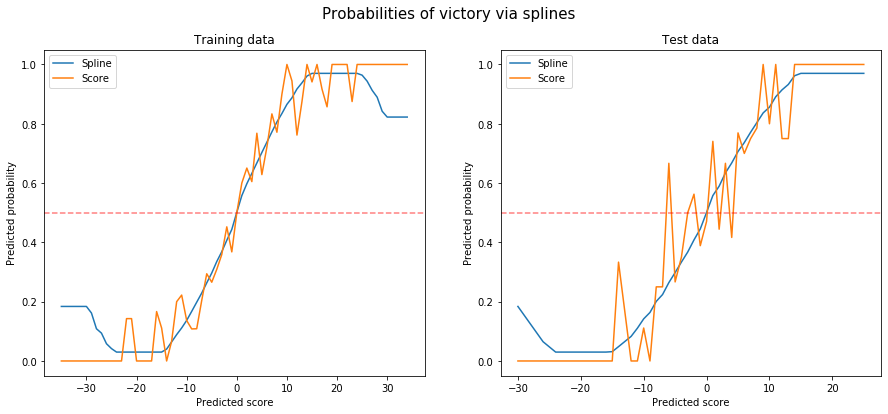

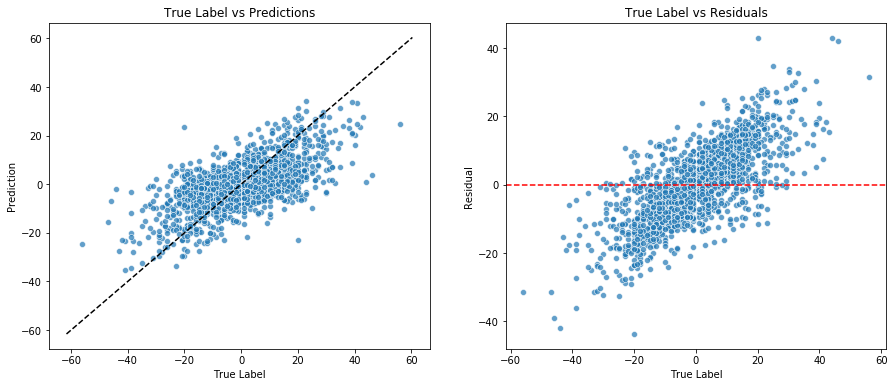

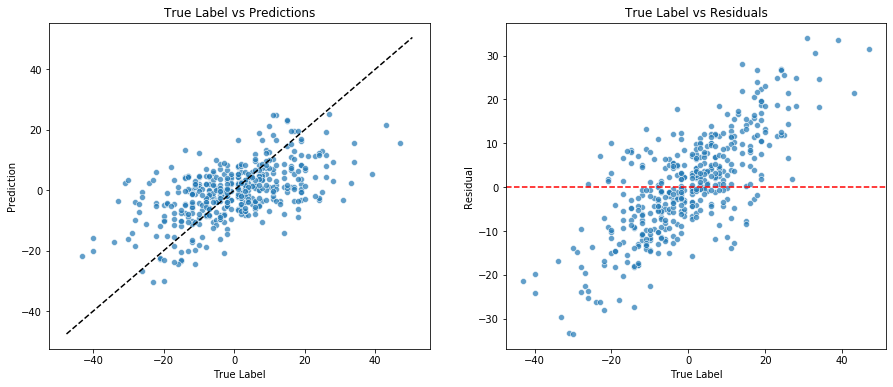

MAE train: 			 8.6484
MAE test: 			 8.8374
RMSE train: 			 11.0253
RMSE test: 			 11.3909
Accuracy train: 		 0.7326
Accuracy test: 			 0.6946
AUC ROC train: 			 0.7326
AUC ROC test: 			 0.6946
Logloss train: 			 0.5307
Logloss test: 			 0.5551
Unsure train: 			 20.9%
Unsure test: 			 22.38%


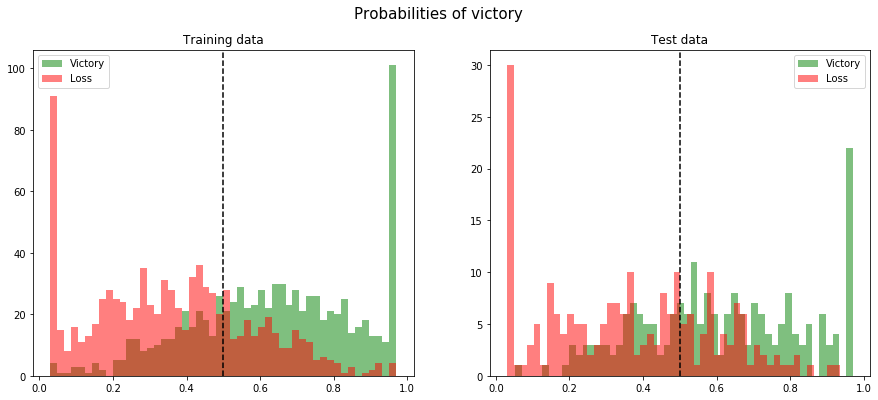

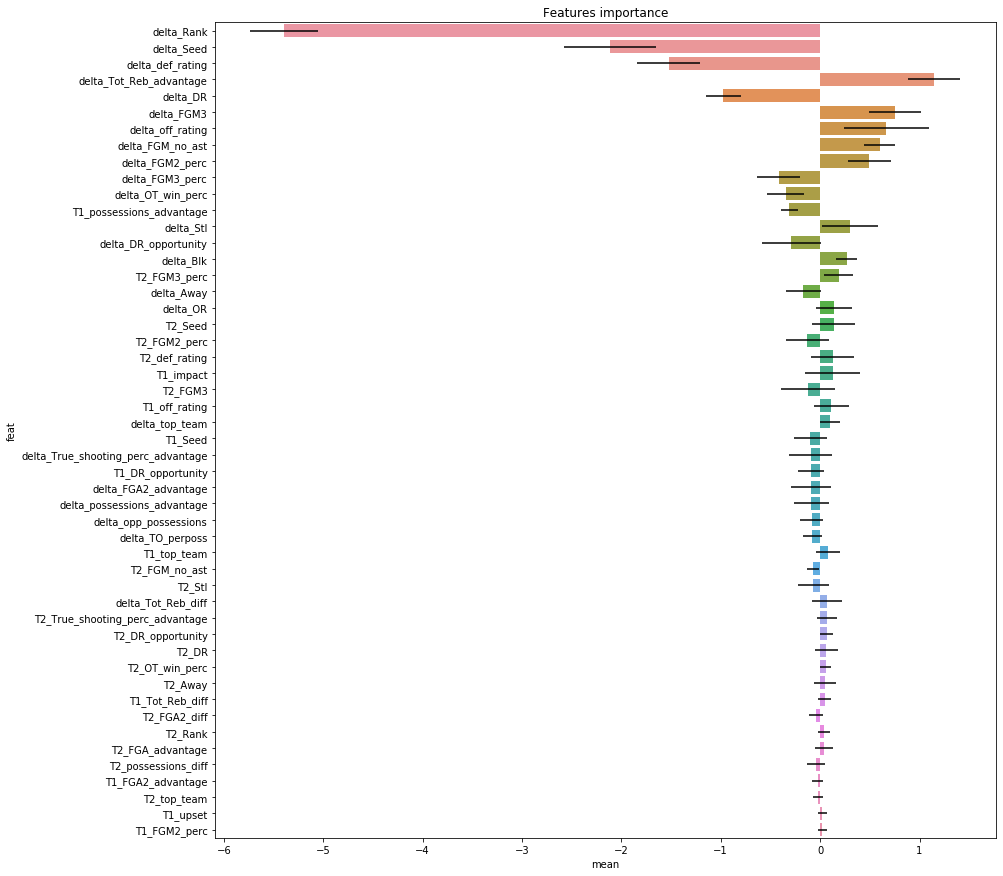

In [22]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('lasso', Lasso(alpha=0.1, max_iter=100000))])


lasso_drop = ([col for col in df if '_DR_opp' in col or '_OR_opp' in col] + 
              [col for col in df if 'N_wins' in col] + 
              [col for col in df if 'FGM2' in col or 'FGA_' in col] + 
              [col for col in df if 'Ast_diff' in col or 'T1_Seed' in col or 'T2_Seed' in col])

df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + 
                                   to_drop, axis=1)


grid = {'lasso__alpha': np.arange(0.05, 0.5, 0.01), 
        'scl__method': ['standard', 'robust'],
        'feat_eng__special': [True, False],
        'feat_sel__k': [70, 100, 120, 150, 170, 'all']}

fitted_las, oof_pred_las, test_pred_las, imp_coef_las, train_las, y_train_las, test_las, y_test_las = random_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.report_points(train_las, test_las, y_train_las, y_test_las, oof_pred_las, test_pred_las, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_las.head(50).reset_index(), 
            xerr=imp_coef_las.head(50)['std'])
plt.title(f'Features importance')
plt.show()

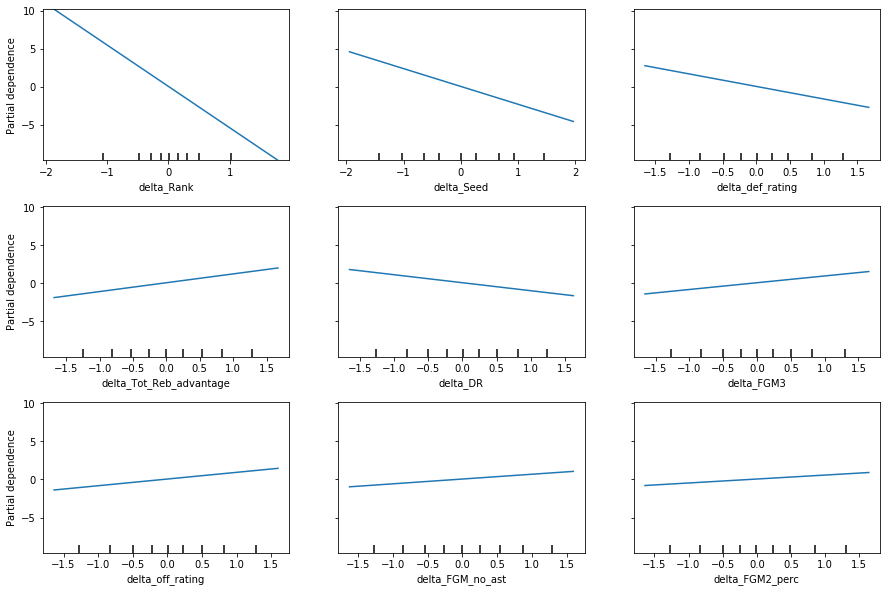

In [23]:
feats = imp_coef_las.head(9).reset_index().feat.values

proc_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k='all'))])

tmp = proc_pipe.fit_transform(train_las, y_train_las)

fig, ax = plt.subplots(3,3, figsize=(15,10))

plot_partial_dependence(fitted_las.steps[-1][1], tmp, feats, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

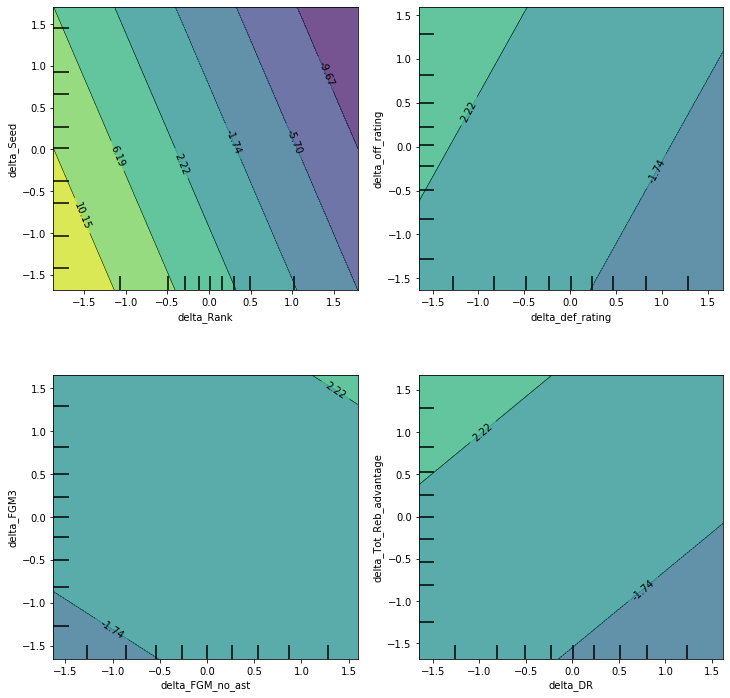

In [24]:
features = [('delta_Rank', 'delta_Seed'), ('delta_def_rating', 'delta_off_rating'), 
            ('delta_FGM_no_ast', 'delta_FGM3'), ('delta_DR', 'delta_Tot_Reb_advantage')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(fitted_las.steps[-1][1], tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

# Ridge

-8.631604942122202
{'feat_eng__special': True, 'feat_sel__k': 30, 'ridge__alpha': 100, 'scl__method': 'standard'}


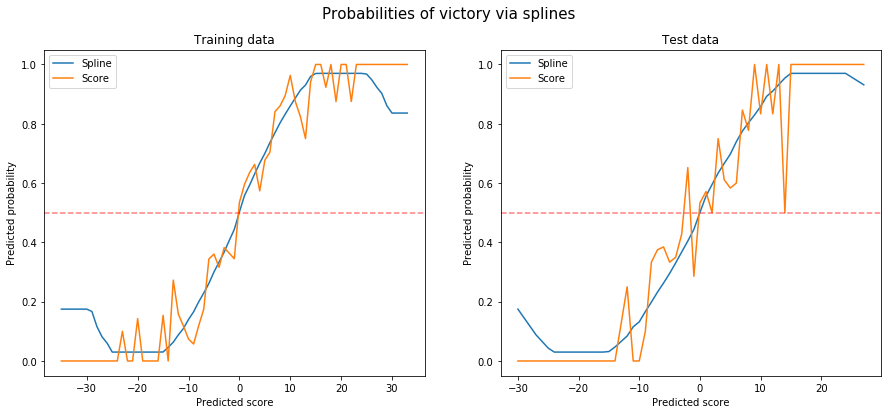

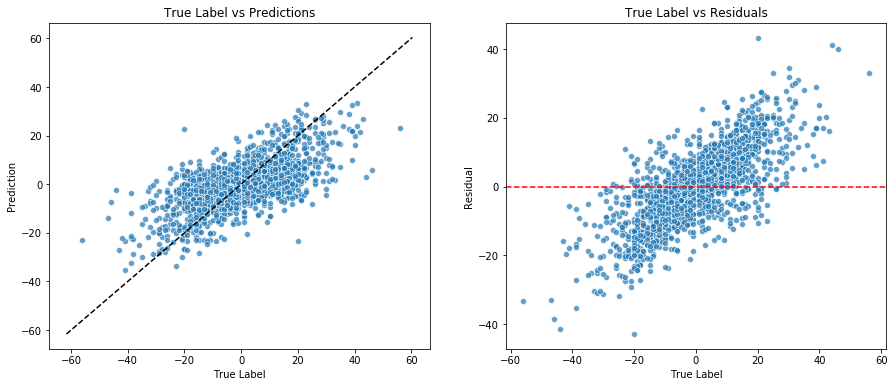

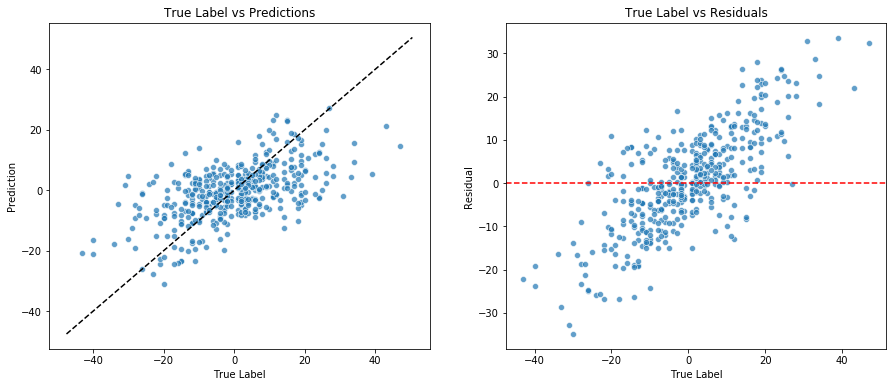

MAE train: 			 8.6295
MAE test: 			 8.765
RMSE train: 			 11.0084
RMSE test: 			 11.3857
Accuracy train: 		 0.7373
Accuracy test: 			 0.6923
AUC ROC train: 			 0.7373
AUC ROC test: 			 0.6923
Logloss train: 			 0.5295
Logloss test: 			 0.5565
Unsure train: 			 20.14%
Unsure test: 			 20.28%


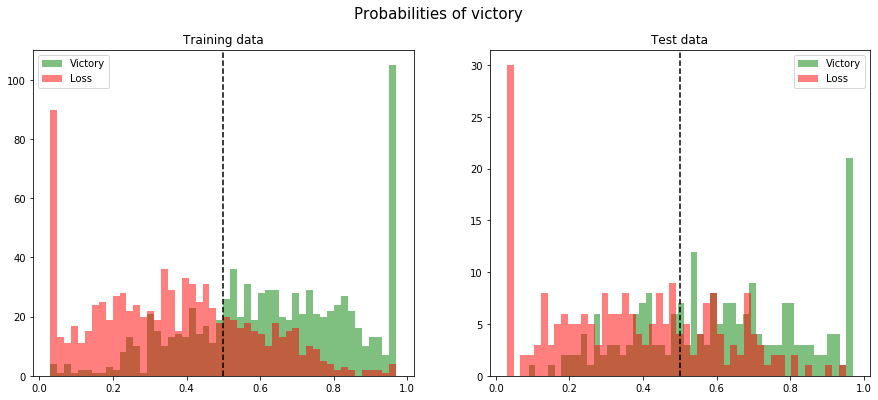

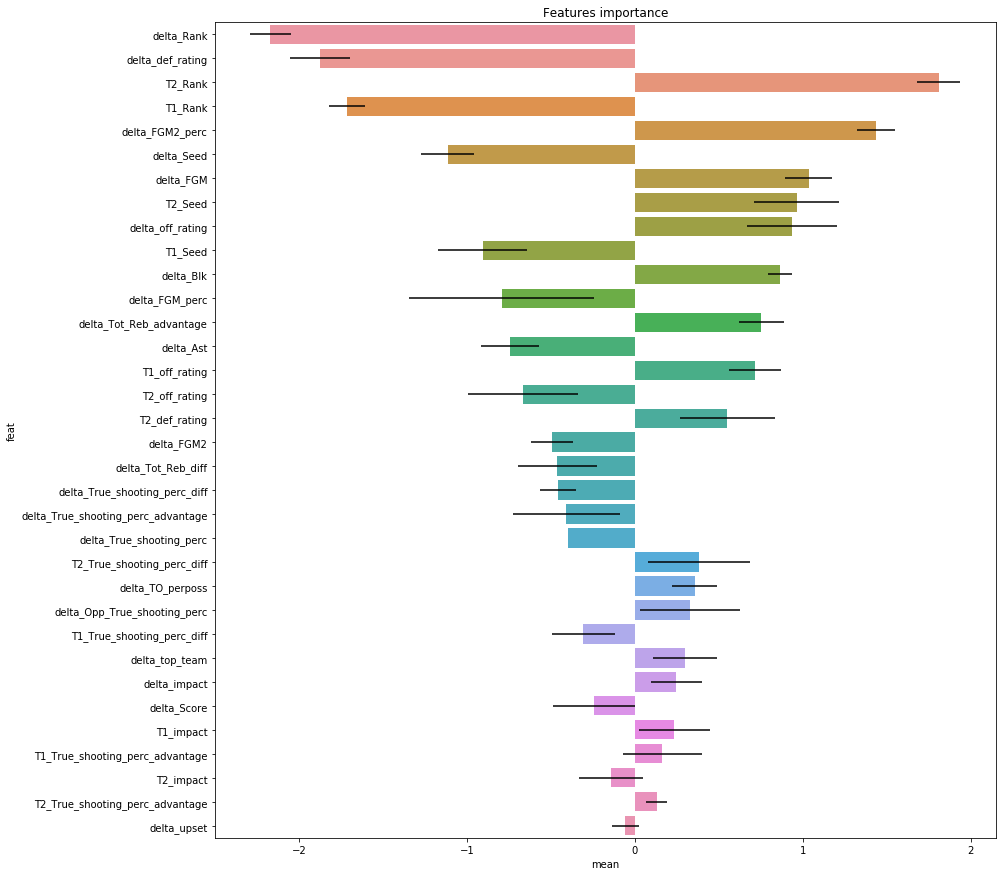

In [25]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('ridge', Ridge())])

df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + to_drop, axis=1)

grid = {'ridge__alpha': np.arange(50, 200, 5), 
        'scl__method': ['standard', 'robust'], 
        'feat_eng__special': [True, False], 
        'feat_sel__k': [10, 20, 30, 50, 70]}

fitted_rid, oof_pred_rid, test_pred_rid, imp_coef_rid, train_rid, y_train_rid, test_rid, y_test_rid = random_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.report_points(train_rid, test_rid, y_train_rid, y_test_rid, oof_pred_rid, test_pred_rid, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_rid.head(50).reset_index(), 
            xerr=imp_coef_rid.head(50)['std'])
plt.title(f'Features importance')
plt.show()

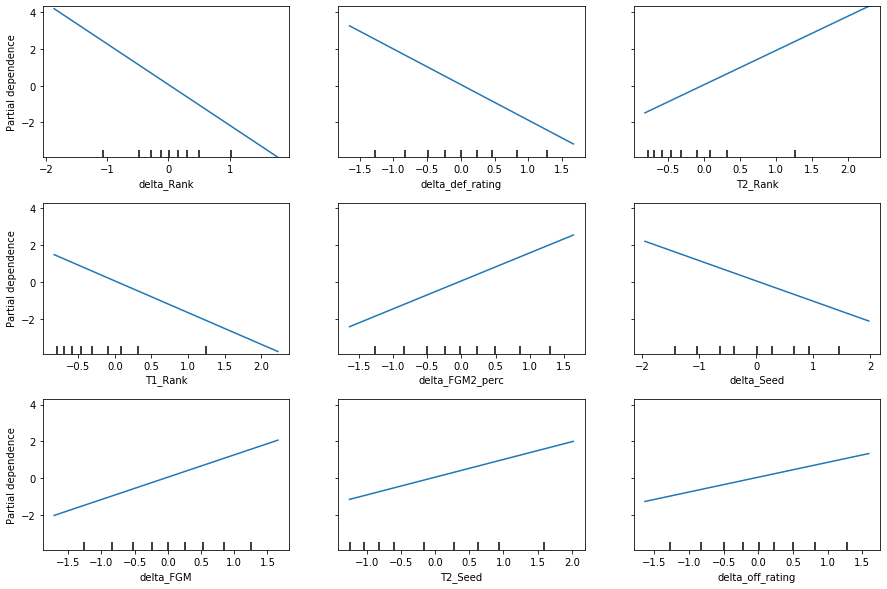

In [26]:
feats = imp_coef_rid.head(9).reset_index().feat.values

proc_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k=30))])

tmp = proc_pipe.fit_transform(train_rid, y_train_rid)

fig, ax = plt.subplots(3,3, figsize=(15,10))

plot_partial_dependence(fitted_rid.steps[-1][1], tmp, feats, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

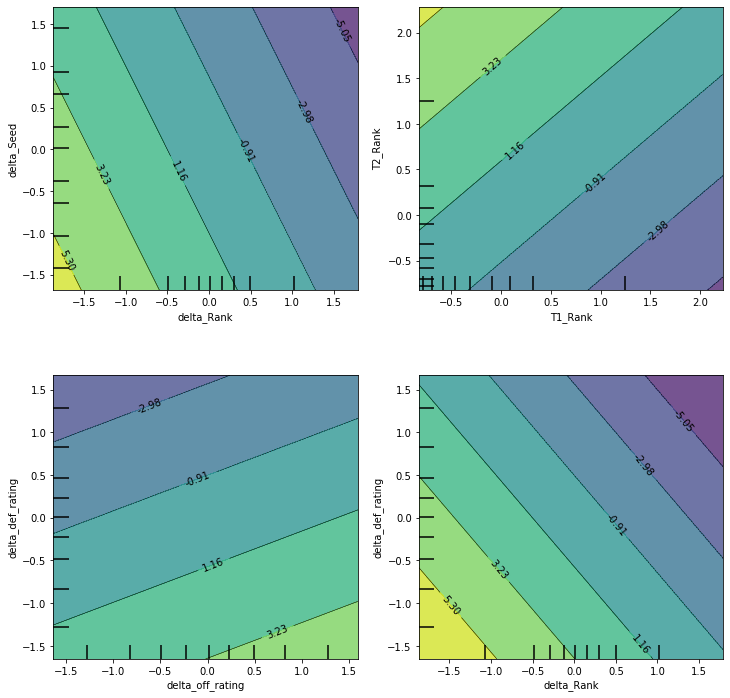

In [27]:
features = [('delta_Rank', 'delta_Seed'), ('T1_Rank', 'T2_Rank'), 
            ('delta_off_rating', 'delta_def_rating'), ('delta_Rank', 'delta_def_rating')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(fitted_rid.steps[-1][1], tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

# Elastic Net

-8.635610986936586
{'feat_eng__special': True, 'feat_sel__k': 'all', 'net__alpha': 0.15000000000000002, 'net__l1_ratio': 0.9, 'scl__method': 'standard'}


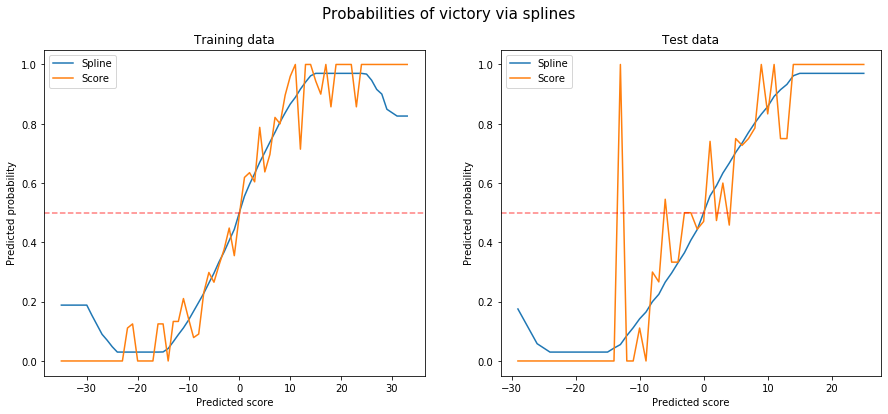

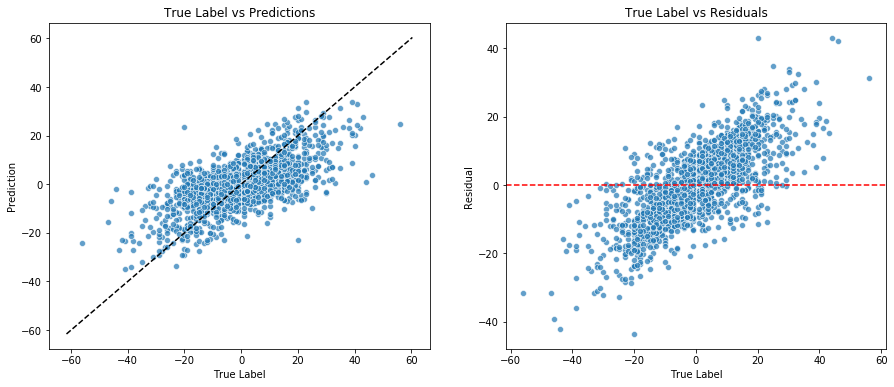

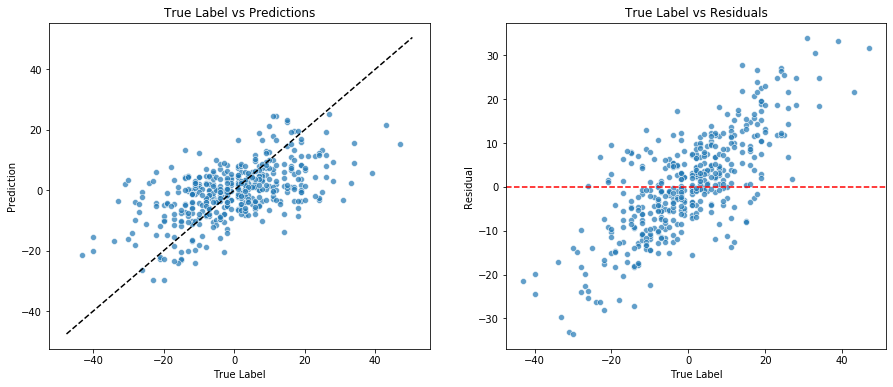

MAE train: 			 8.6537
MAE test: 			 8.8186
RMSE train: 			 11.0302
RMSE test: 			 11.3802
Accuracy train: 		 0.7338
Accuracy test: 			 0.6876
AUC ROC train: 			 0.7338
AUC ROC test: 			 0.6876
Logloss train: 			 0.5306
Logloss test: 			 0.5542
Unsure train: 			 20.72%
Unsure test: 			 22.38%


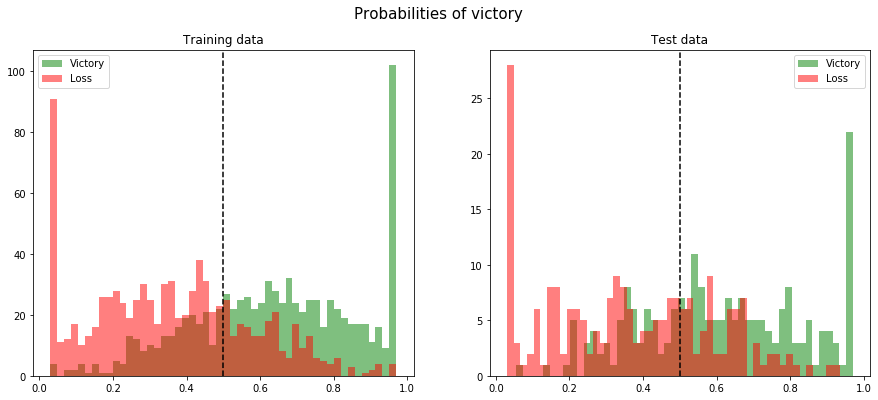

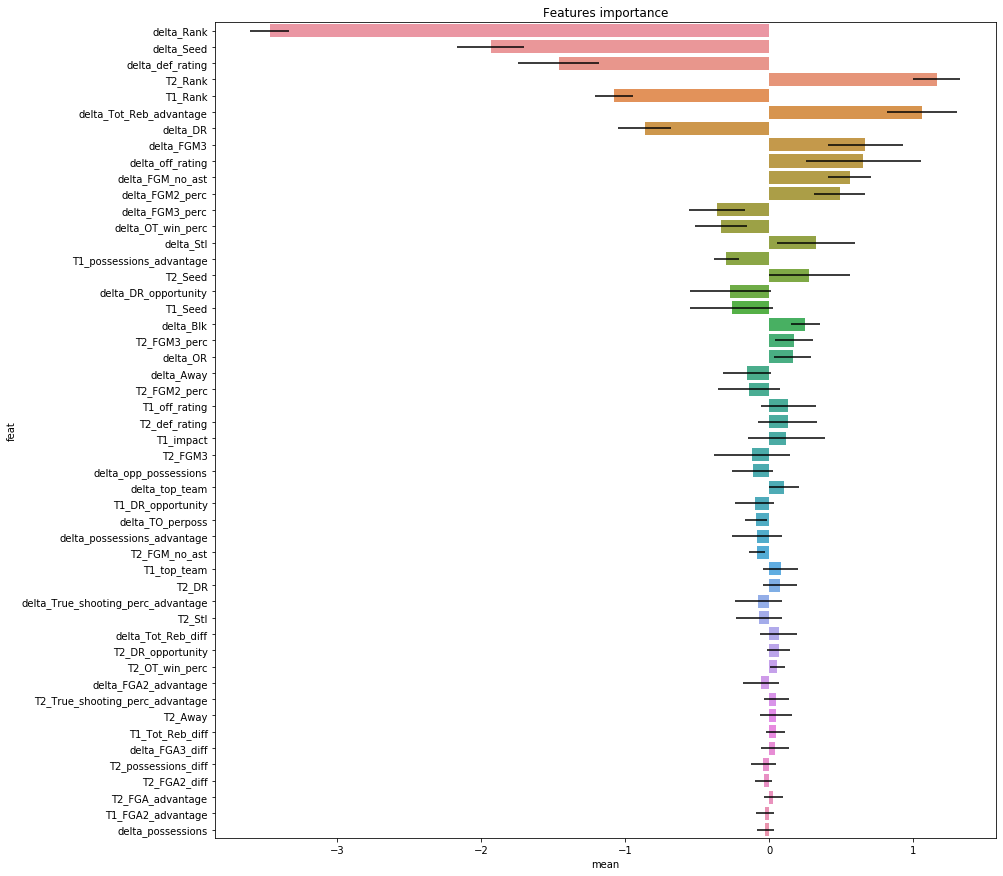

In [28]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('net', ElasticNet(max_iter=5000))])

df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + to_drop, axis=1)

grid = {'net__alpha': np.arange(0.1, 1, 0.05), 
        'net__l1_ratio': np.arange(0.1, 1, 0.1),
        'scl__method': ['standard', 'robust'], 
        'feat_eng__special': [True, False], 
        'feat_sel__k': [70, 100, 120, 150, 170, 'all']}

fitted_net, oof_pred_net, test_pred_net, imp_coef_net, train_net, y_train_net, test_net, y_test_net = random_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.report_points(train_net, test_net, y_train_net, y_test_net, oof_pred_net, test_pred_net, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_net.head(50).reset_index(), 
            xerr=imp_coef_net.head(50)['std'])
plt.title(f'Features importance')
plt.show()

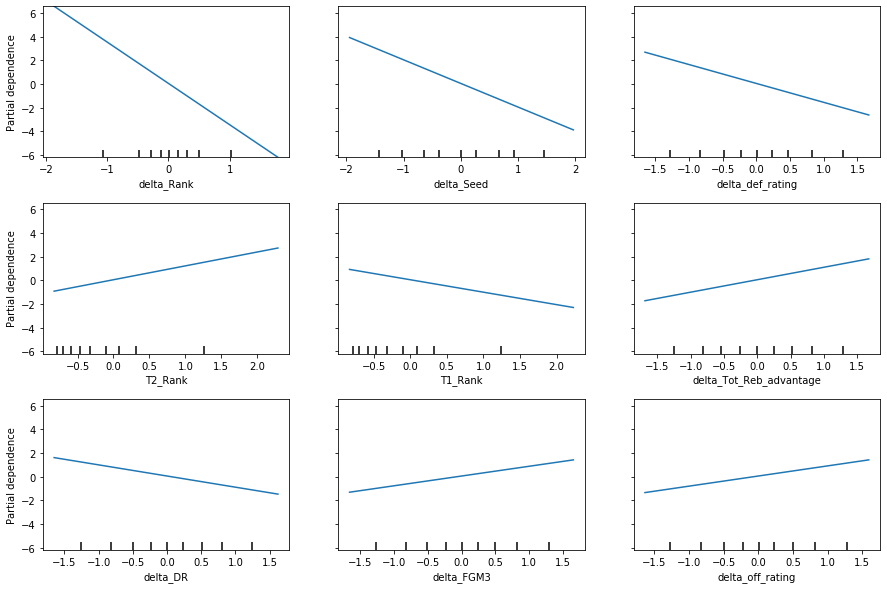

In [29]:
feats = imp_coef_net.head(9).reset_index().feat.values

proc_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k='all'))])

tmp = proc_pipe.fit_transform(train_net, y_train_net)

fig, ax = plt.subplots(3,3, figsize=(15,10))

plot_partial_dependence(fitted_net.steps[-1][1], tmp, feats, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

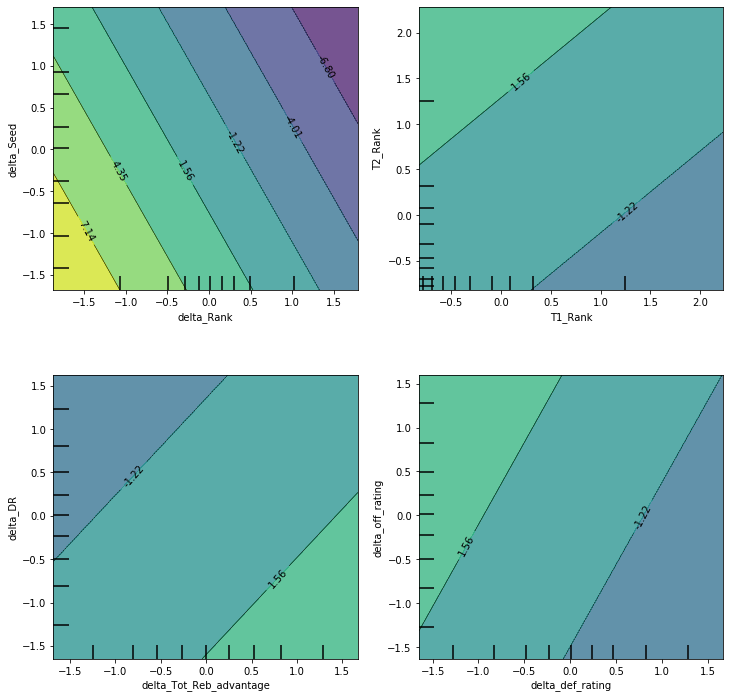

In [30]:
features = [('delta_Rank', 'delta_Seed'), ('T1_Rank', 'T2_Rank'), 
            ('delta_Tot_Reb_advantage', 'delta_DR'), ('delta_def_rating', 'delta_off_rating')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(fitted_net.steps[-1][1], tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

# Logit

-0.5312796402100997
{'feat_sel__k': 20, 'logit__C': 0.031, 'scl__method': 'standard'}
Accuracy train: 		 0.7315
Accuracy test: 			 0.6807
AUC ROC train: 			 0.7315
AUC ROC test: 			 0.6805
Logloss train: 			 0.5313
Logloss test: 			 0.5542
Unsure train: 			 22.5919%
Unsure test: 			 22.8438%


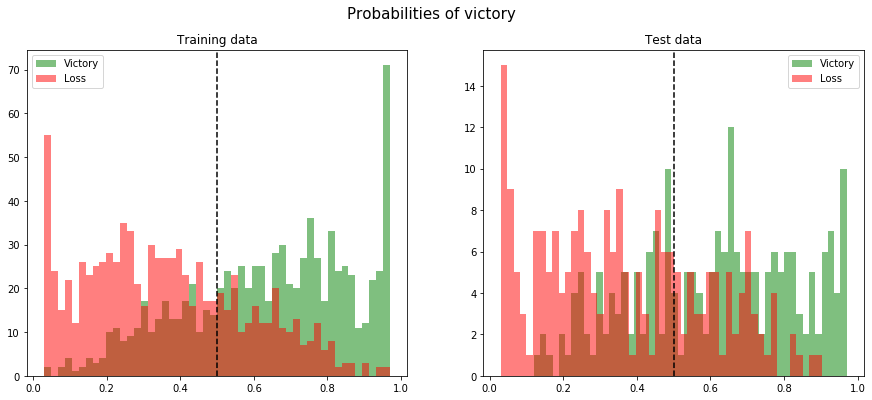

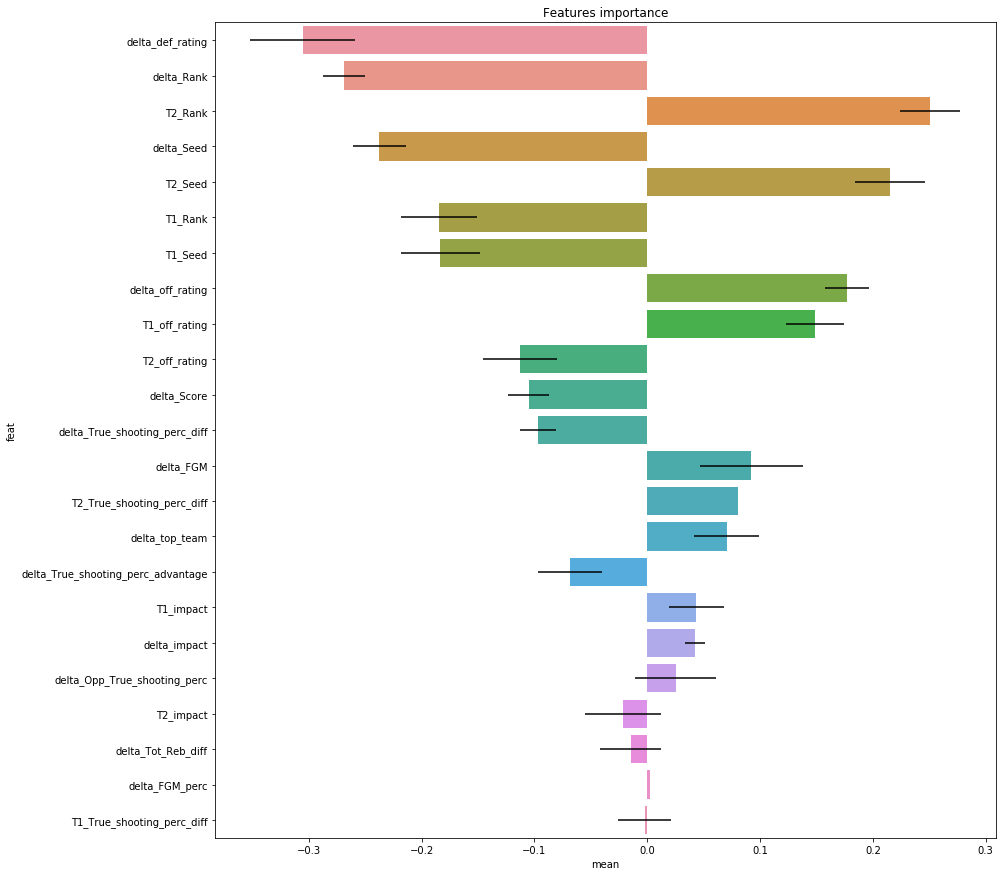

In [11]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('logit', LogisticRegression(solver='lbfgs', max_iter=5000))])

df_train = df[standard + special_selection]#.drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + to_drop, axis=1)

grid = {'logit__C': np.arange(0.001, 0.2, 0.005), 
        'scl__method': ['standard', 'robust'], 
        #'feat_eng__lastyr': [True, False], 
        'feat_sel__k': [5, 10, 20, 50, 70, 100, 'all']}


fitted_log, oof_pred_log, test_pred_log, imp_coef_log, train_log, y_train_log, test_log, y_test_log = random_split(df_train, pipe, kfolds, 'target', predict_proba=True, tune=True, param_grid=grid)

rp.report_victory(y_train_log, y_test_log, oof_pred_log, test_pred_log, probs=True, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_log.head(50).reset_index(), 
            xerr=imp_coef_log.head(50)['std'])
plt.title(f'Features importance')
plt.show()

# Forest

-8.72122476370377
{'feat_eng__special': True, 'feat_sel__k': 5, 'forest__max_depth': 7, 'forest__min_samples_leaf': 2}


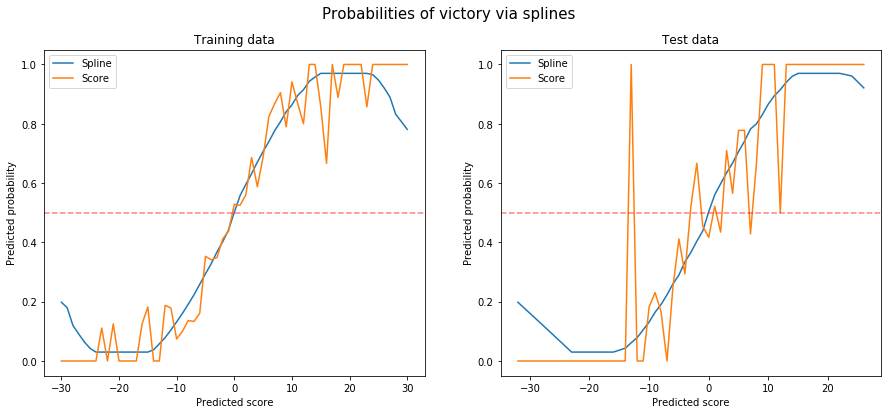

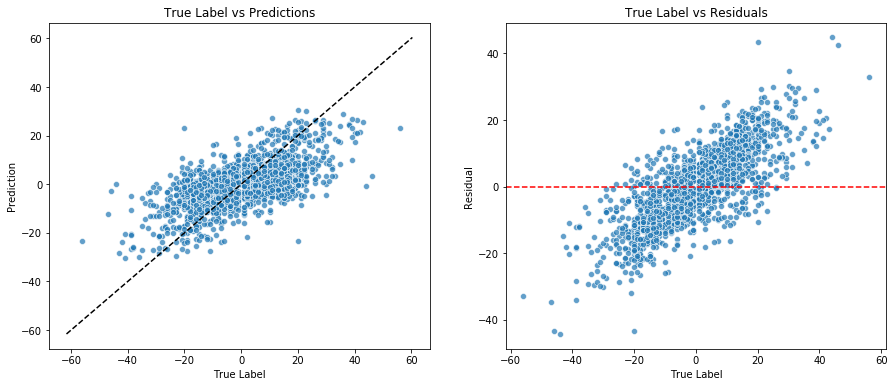

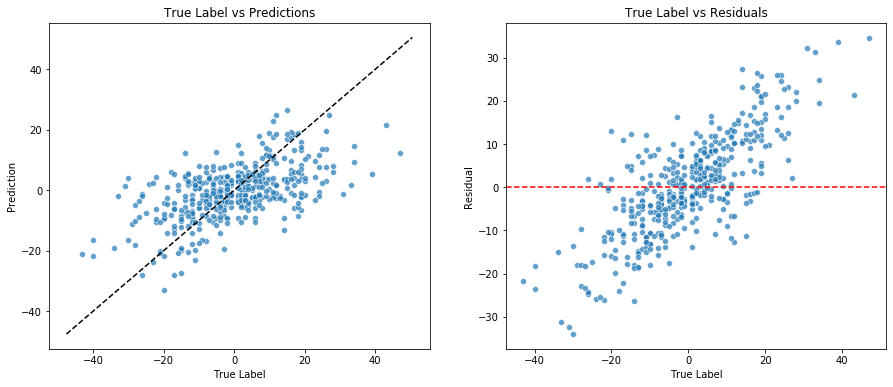

MAE train: 			 8.7303
MAE test: 			 8.7979
RMSE train: 			 11.0945
RMSE test: 			 11.3594
Accuracy train: 		 0.7163
Accuracy test: 			 0.6713
AUC ROC train: 			 0.7163
AUC ROC test: 			 0.6713
Logloss train: 			 0.5354
Logloss test: 			 0.5581
Unsure train: 			 18.21%
Unsure test: 			 21.45%


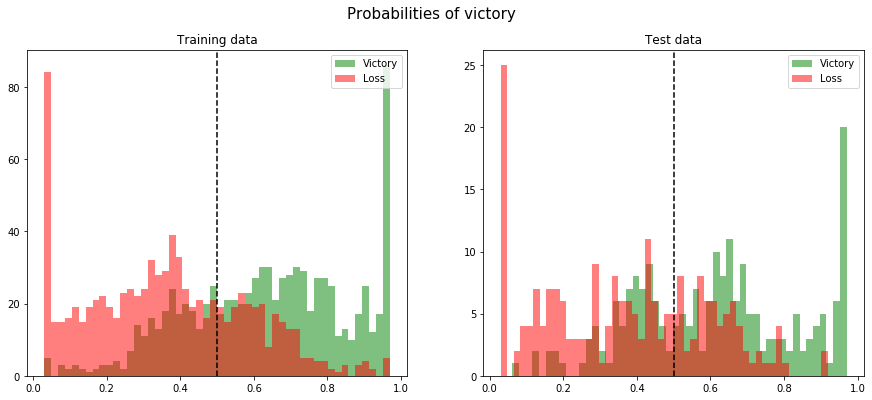

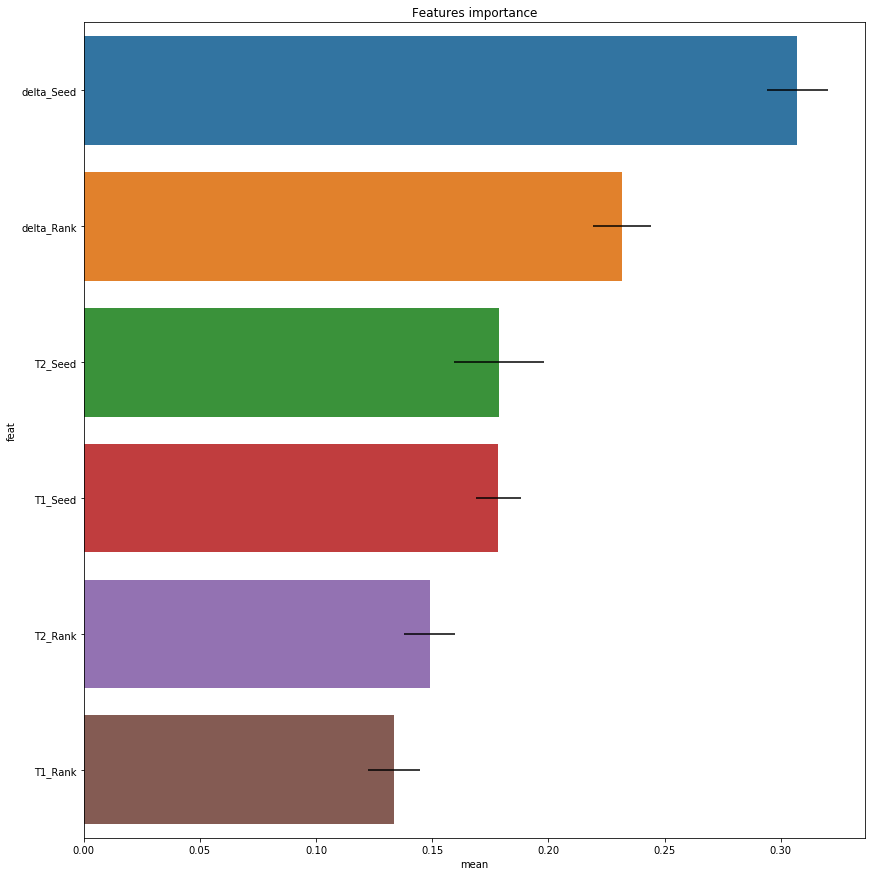

In [31]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k='all'))] + [('forest', ExtraTreesRegressor(n_estimators=700, 
                                                                                max_features='sqrt',
                                                                                n_jobs=5))])

df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc'], axis=1)

grid = {'forest__max_depth': [3, 5, 7, 10, 20, None], 
        'forest__min_samples_leaf': [1, 2, 4, 8, 16, 32, 64],
        'feat_sel__k': [5, 10, 20, 50, 100,'all'],
        'feat_eng__special': [True, False]}


fitted_for, oof_pred_for, test_pred_for, imp_coef_for, train_for, y_train_for, test_for, y_test_for = random_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.report_points(train_for, test_for, y_train_for, y_test_for, oof_pred_for, test_pred_for, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef_for.head(50).reset_index(), 
            xerr=imp_coef_for.head(50)['std'])
plt.title(f'Features importance')
plt.show()

ValueError: Number of features of the model must match the input. Model n_features is 5 and input n_features is 10 

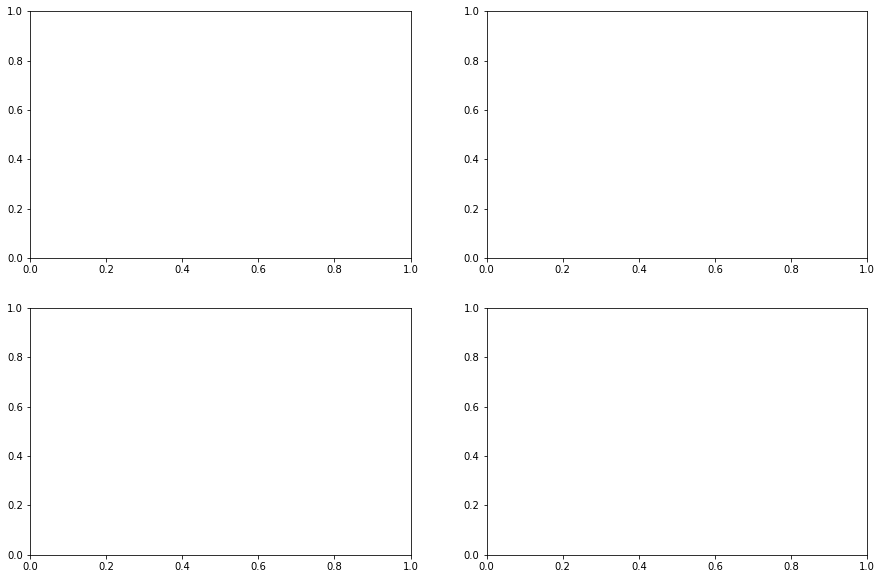

In [34]:
feats = imp_coef_for.reset_index().head(4).feat.values

proc_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k=10))])

tmp = proc_pipe.fit_transform(train_for, y_train_for)

fig, ax = plt.subplots(2,2, figsize=(15,10))

plot_partial_dependence(fitted_for.steps[-1][1], tmp, feats, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

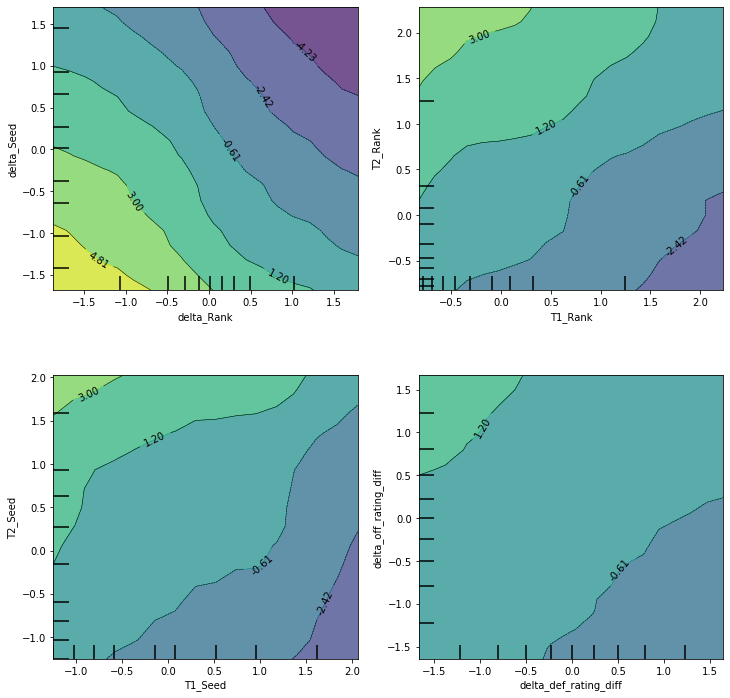

In [39]:
features = [('delta_Rank', 'delta_Seed'), ('T1_Rank', 'T2_Rank'), 
            ('T1_Seed', 'T2_Seed'), ('delta_def_rating_diff', 'delta_off_rating_diff')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(fitted_for.steps[-1][1], tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

# XGBoost

In [69]:
def cauchyobj(preds, labels):
    c = 5000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [76]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=5000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

fold n°1
[0]	validation_0-mae:10.88849	validation_1-mae:11.55048
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[100]	validation_0-mae:3.36212	validation_1-mae:9.28079
Stopping. Best iteration:
[56]	validation_0-mae:4.87482	validation_1-mae:9.10838

fold n°2
[0]	validation_0-mae:10.91725	validation_1-mae:11.32706
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[100]	validation_0-mae:3.35564	validation_1-mae:9.30624
Stopping. Best iteration:
[32]	validation_0-mae:6.03241	validation_1-mae:9.11689

fold n°3
[0]	validation_0-mae:11.12113	validation_1-mae:10.64653
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[100]	validation_0-mae:3.54220	validation_1-mae:8.69800

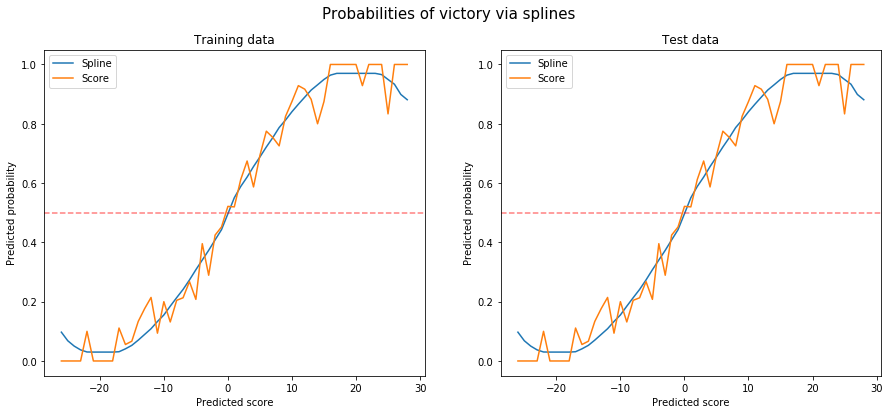

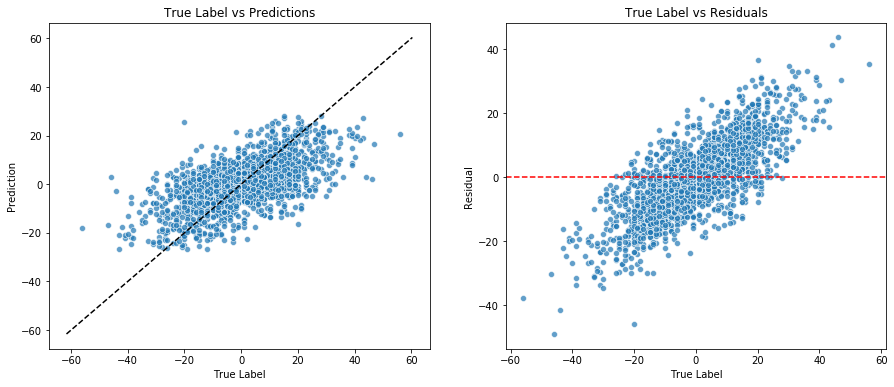

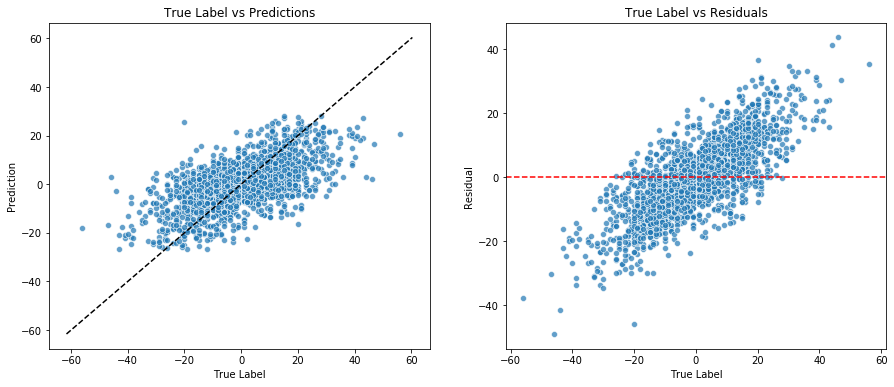

MAE train: 			 8.8316
MAE test: 			 8.8316
RMSE train: 			 11.3698
RMSE test: 			 11.3698
Accuracy train: 		 0.7082
Accuracy test: 			 0.7082
AUC ROC train: 			 0.7082
AUC ROC test: 			 0.7082
Logloss train: 			 0.5455
Logloss test: 			 0.5455
Unsure train: 			 23.16%
Unsure test: 			 23.16%


,mean,std
feature,,
delta_Rank,0.130931,0.010109
T2_Rank,0.050435,0.006708
T1_Rank,0.030771,0.012819
T1_Seed,0.029777,0.032774
delta_Seed,0.021329,0.014068
...,...,...
T1_OT_win_perc,0.002941,0.001200
delta_Ast,0.002744,0.001056
T2_OT_win_perc,0.002554,0.000791


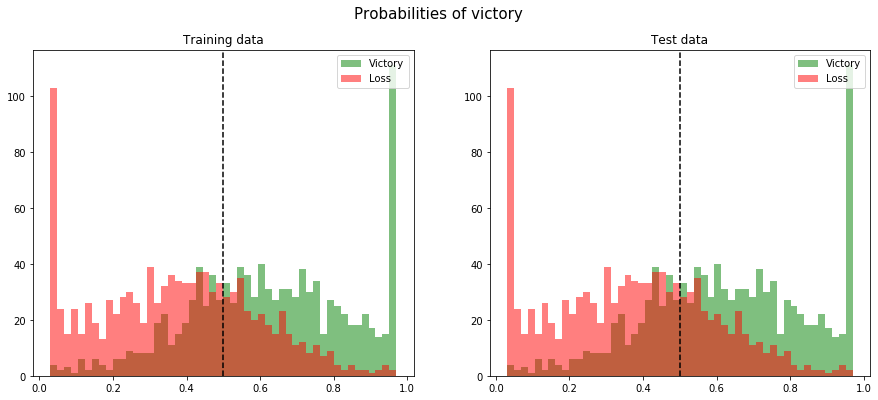

In [94]:
oof = np.zeros(len(train))
feature_importance_df = pd.DataFrame()

train = df[special_selection].copy()
y_train = df['target_points']

for col in ['target', 'target_points', 'ID', 'DayNum', 'Team1', 'Team2', 'Season']:
    try:
        del train[col]
    except KeyError:
        pass

for n_fold, (train_index, test_index) in enumerate(kfolds.split(train.values)):
    print("fold n°{}".format(n_fold+1))

    trn_data = train.iloc[train_index][:]
    val_data = train.iloc[test_index][:]

    trn_target = y_train.iloc[train_index].values.ravel()
    val_target = y_train.iloc[test_index].values.ravel()

    clf = xgb1.fit(trn_data, trn_target, 
                   eval_set=[(trn_data, trn_target), (val_data, val_target)],
                   eval_metric='mae',
                   early_stopping_rounds=100, verbose=100)

    oof[test_index] = clf.predict(train.iloc[test_index], ntree_limit=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = special_selection
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

rp.report_points(train, train, y_train, y_train, oof, oof, plot=True)
    
feature_importance_df = feature_importance_df.groupby('feature')['importance'].agg(['mean', 'std'])
feature_importance_df['abs_sco'] = (abs(feature_importance_df['mean']))
feature_importance_df = feature_importance_df.sort_values(by=['abs_sco'],ascending=False)
del feature_importance_df['abs_sco']
feature_importance_df

In [96]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

gsearch1 = GridSearchCV(estimator = xgb2, param_grid = param_test1, scoring='neg_mean_absolute_error',
                        n_jobs=-1, cv=kfolds)

gsearch1.fit(train, y_train)

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [97]:
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 3, 'min_child_weight': 3} -8.76992166546717


In [108]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=50,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)


gsearch2 = GridSearchCV(estimator = xgb3, param_grid = param_test2, scoring='neg_mean_absolute_error',
                        n_jobs=-1, cv=kfolds)
                        
gsearch2.fit(train, y_train)
                        
print(gsearch2.best_params_, gsearch2.best_score_)

{'gamma': 0.0} -8.76992166546717


In [109]:
xgb4 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=60,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_test3 = {
 'subsample':[i/100 for i in range(50,70, 5)],
 'colsample_bytree':[i/100 for i in range(50,70, 5)]
}

gsearch3 = GridSearchCV(estimator = xgb4, param_grid = param_test3, scoring='neg_mean_absolute_error',
                        n_jobs=-1, cv=kfolds)
                        
gsearch3.fit(train, y_train)
                        
print(gsearch3.best_params_, gsearch3.best_score_)

{'colsample_bytree': 0.55, 'subsample': 0.65} -8.750108952605109


In [111]:
xgb5 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=60,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.55,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

param_test4 = {
 'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch4 = GridSearchCV(estimator = xgb5, param_grid = param_test4, scoring='neg_mean_absolute_error',
                        n_jobs=-1, cv=kfolds)
                        
gsearch4.fit(train, y_train)
                        
print(gsearch4.best_params_, gsearch4.best_score_)

{'reg_alpha': 0.1} -8.749735345167583


fold n°1
[0]	validation_0-mae:11.37793	validation_1-mae:12.00011
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[100]	validation_0-mae:8.91695	validation_1-mae:9.61799
[200]	validation_0-mae:8.22195	validation_1-mae:9.10200
[300]	validation_0-mae:7.87676	validation_1-mae:8.98379
[400]	validation_0-mae:7.61695	validation_1-mae:8.95082
[500]	validation_0-mae:7.39249	validation_1-mae:8.93597
Stopping. Best iteration:
[498]	validation_0-mae:7.39766	validation_1-mae:8.93387

fold n°2
[0]	validation_0-mae:11.43090	validation_1-mae:11.77828
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[100]	validation_0-mae:8.87129	validation_1-mae:9.45340
[200]	validation_0-mae:8.17662	validation_1-mae:9.07257
[300]	validation_0-mae:7.83031	validation_1-mae:9.01173
[400]	validation_0-mae:

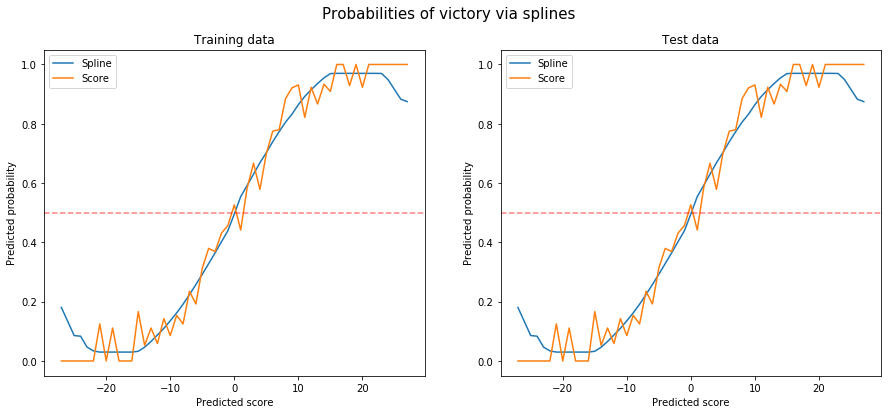

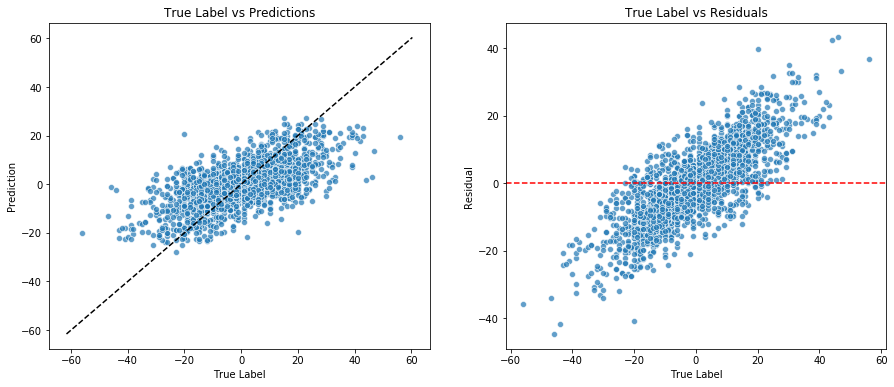

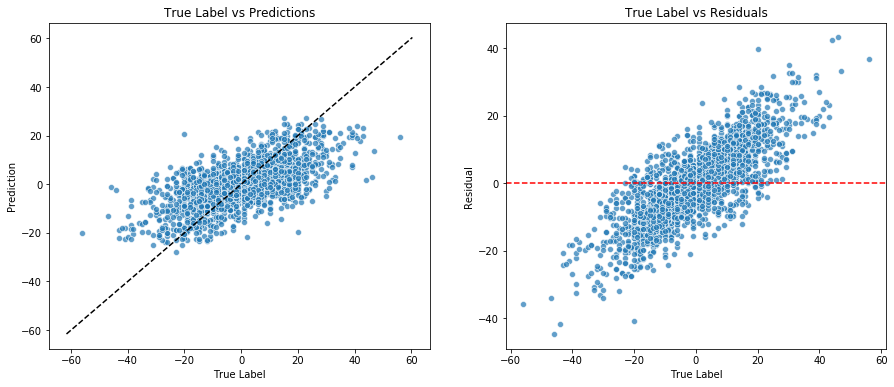

MAE train: 			 8.6998
MAE test: 			 8.6998
RMSE train: 			 11.1756
RMSE test: 			 11.1756
Accuracy train: 		 0.712
Accuracy test: 			 0.712
AUC ROC train: 			 0.712
AUC ROC test: 			 0.712
Logloss train: 			 0.5359
Logloss test: 			 0.5359
Unsure train: 			 20.68%
Unsure test: 			 20.68%


,mean,std
feature,,
delta_Seed,0.066588,0.008559
delta_Rank,0.054798,0.003269
T1_Seed,0.032548,0.007635
T2_Rank,0.025427,0.001660
T1_Rank,0.023738,0.002464
...,...,...
T2_Ast,0.005078,0.000494
T2_Away,0.005020,0.000650
T1_OT_win_perc,0.004460,0.000734


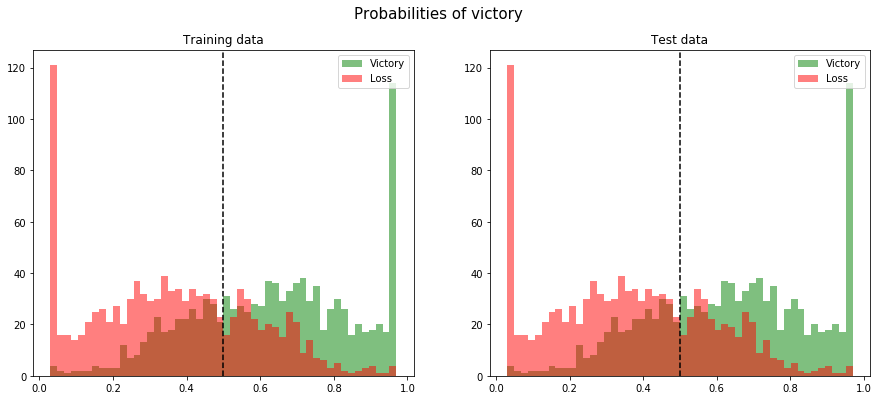

In [112]:
xgb6 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=6000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.65,
 colsample_bytree=0.55,
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.05,
 seed=27)

oof = np.zeros(len(train))
feature_importance_df = pd.DataFrame()

for n_fold, (train_index, test_index) in enumerate(kfolds.split(train.values)):
    print("fold n°{}".format(n_fold+1))

    trn_data = train.iloc[train_index][:]
    val_data = train.iloc[test_index][:]

    trn_target = y_train.iloc[train_index].values.ravel()
    val_target = y_train.iloc[test_index].values.ravel()

    clf = xgb6.fit(trn_data, trn_target, 
                   eval_set=[(trn_data, trn_target), (val_data, val_target)],
                   eval_metric='mae',
                   early_stopping_rounds=100, verbose=100)

    oof[test_index] = clf.predict(train.iloc[test_index], ntree_limit=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = special_selection
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

rp.report_points(train, train, y_train, y_train, oof, oof, plot=True)
    
feature_importance_df = feature_importance_df.groupby('feature')['importance'].agg(['mean', 'std'])
feature_importance_df['abs_sco'] = (abs(feature_importance_df['mean']))
feature_importance_df = feature_importance_df.sort_values(by=['abs_sco'],ascending=False)
del feature_importance_df['abs_sco']
feature_importance_df

# All together

In [12]:
df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc'] + 
                                   to_drop, axis=1)

oof_las = np.zeros(len(df_train))
oof_ridge = np.zeros(len(df_train))
oof_net = np.zeros(len(df_train))
oof_forest = np.zeros(len(df_train))
oof_xgb = np.zeros(len(df_train))

train = df_train.copy()
y_train = train['target_points']

for col in ['target', 'target_points', 'ID', 'DayNum', 'Team1', 'Team2', 'Season']:
    try:
        del train[col]
    except KeyError:
        pass

feat_df_las = pd.DataFrame()
feat_df_ridge = pd.DataFrame()
feat_df_net = pd.DataFrame()
feat_df_forest = pd.DataFrame()
feat_df_xgb = pd.DataFrame()

lasso_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k='all'))] + 
                      [('lasso', Lasso(alpha=0.13, max_iter=100000))])

ridge_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k=30))] + 
                      [('ridge', Ridge(alpha=100))])

net_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k='all'))] + 
                    [('net', ElasticNet(max_iter=5000, alpha=0.15, l1_ratio=0.9))])

forest_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k=10))] + 
                       [('forest', ExtraTreesRegressor(n_estimators=700, 
                                                       max_depth=7,
                                                       min_samples_leaf=2,
                                                       max_features='sqrt',
                                                       n_jobs=5))])

xgb_pipe = Pipeline([('feat_eng', feat_eng(special=True)), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg', k='all'))]) 
xgb_reg = XGBRegressor(learning_rate =0.01,
                                             n_estimators=6000,
                                             max_depth=3,
                                             min_child_weight=3,
                                             gamma=0,
                                             subsample=0.65,
                                             colsample_bytree=0.55,
                                             nthread=4,
                                             scale_pos_weight=1,
                                             reg_alpha=0.05,
                                             seed=27)

for n_fold, (train_index, test_index) in enumerate(kfolds.split(train.values)):
    print(n_fold+1)

    trn_data = train.iloc[train_index][:]
    val_data = train.iloc[test_index][:]

    trn_target = y_train.iloc[train_index].values.ravel()
    val_target = y_train.iloc[test_index].values.ravel()

    lasso_pipe.fit(trn_data, trn_target)
    ridge_pipe.fit(trn_data, trn_target)
    net_pipe.fit(trn_data, trn_target)
    forest_pipe.fit(trn_data, trn_target)
    xg_train = xgb_pipe.fit_transform(trn_data, trn_target)
    xg_test = xgb_pipe.transform(val_data)
    clf = xgb_reg.fit(xg_train, trn_target, 
                   eval_set=[(xg_test, val_target)],
                   eval_metric='mae',
                   verbose=300,
                   early_stopping_rounds=150)

    oof_las[test_index] = lasso_pipe.predict(val_data).ravel()
    oof_ridge[test_index] = ridge_pipe.predict(val_data).ravel()
    oof_net[test_index] = net_pipe.predict(val_data).ravel()
    oof_forest[test_index] = forest_pipe.predict(val_data).ravel()
    
    oof_xgb[test_index] = clf.predict(xg_test, ntree_limit=clf.best_iteration).ravel()
    
    fold_df = rp.get_coef(lasso_pipe)
    fold_df['fold'] = n_fold + 1
    feat_df_las = pd.concat([feat_df_las, fold_df], axis=0)
    fold_df = rp.get_coef(ridge_pipe)
    fold_df['fold'] = n_fold + 1
    feat_df_ridge = pd.concat([feat_df_ridge, fold_df], axis=0)
    fold_df = rp.get_coef(net_pipe)
    fold_df['fold'] = n_fold + 1
    feat_df_net = pd.concat([feat_df_net, fold_df], axis=0)
    fold_df = rp.get_feature_importance(forest_pipe)
    fold_df['fold'] = n_fold + 1
    feat_df_forest = pd.concat([feat_df_forest, fold_df], axis=0)
    imps = clf.feature_importances_.tolist()
    feats = xg_train.columns
    fold_df = pd.DataFrame({'feat': feats, 'score': imps})
    fold_df['fold'] = n_fold + 1
    feat_df_xgb = pd.concat([feat_df_xgb, fold_df], axis=0)


feat_df_las = feat_df_las.groupby('feat')['score'].agg(['mean', 'std'])
feat_df_las['abs_sco'] = (abs(feat_df_las['mean']))
feat_df_las = feat_df_las.sort_values(by=['abs_sco'],ascending=False)
del feat_df_las['abs_sco']
feat_df_ridge = feat_df_ridge.groupby('feat')['score'].agg(['mean', 'std'])
feat_df_ridge['abs_sco'] = (abs(feat_df_ridge['mean']))
feat_df_ridge = feat_df_ridge.sort_values(by=['abs_sco'],ascending=False)
del feat_df_ridge['abs_sco']
feat_df_net = feat_df_net.groupby('feat')['score'].agg(['mean', 'std'])
feat_df_net['abs_sco'] = (abs(feat_df_net['mean']))
feat_df_net = feat_df_net.sort_values(by=['abs_sco'],ascending=False)
del feat_df_net['abs_sco']
feat_df_forest = feat_df_forest.groupby('feat')['score'].agg(['mean', 'std'])
feat_df_forest['abs_sco'] = (abs(feat_df_forest['mean']))
feat_df_forest = feat_df_forest.sort_values(by=['abs_sco'],ascending=False)
del feat_df_forest['abs_sco']
feat_df_xgb = feat_df_xgb.groupby('feat')['score'].agg(['mean', 'std'])
feat_df_xgb['abs_sco'] = (abs(feat_df_xgb['mean']))
feat_df_xgb = feat_df_xgb.sort_values(by=['abs_sco'],ascending=False)
del feat_df_xgb['abs_sco']

1
[0]	validation_0-mae:12.00446
Will train until validation_0-mae hasn't improved in 150 rounds.
[300]	validation_0-mae:8.99458
[600]	validation_0-mae:8.93288
[900]	validation_0-mae:8.91624
Stopping. Best iteration:
[815]	validation_0-mae:8.90429

2
[0]	validation_0-mae:11.78307
Will train until validation_0-mae hasn't improved in 150 rounds.
[300]	validation_0-mae:9.00647
Stopping. Best iteration:
[274]	validation_0-mae:9.00390

3
[0]	validation_0-mae:11.02440
Will train until validation_0-mae hasn't improved in 150 rounds.
[300]	validation_0-mae:8.30212
Stopping. Best iteration:
[330]	validation_0-mae:8.29172

4
[0]	validation_0-mae:11.59440
Will train until validation_0-mae hasn't improved in 150 rounds.
[300]	validation_0-mae:8.91807
[600]	validation_0-mae:8.89833
Stopping. Best iteration:
[483]	validation_0-mae:8.89481

5
[0]	validation_0-mae:11.12465
Will train until validation_0-mae hasn't improved in 150 rounds.
[300]	validation_0-mae:8.45257
[600]	validation_0-mae:8.38542
[900

In [13]:
rp.report_points(train, train, y_train, y_train, oof_las, oof_las, plot=False)
feat_df_las.head()

MAE train: 			 8.6872
MAE test: 			 8.6872
RMSE train: 			 11.1038
RMSE test: 			 11.1038
Accuracy train: 		 0.7241
Accuracy test: 			 0.7241
AUC ROC train: 			 0.7241
AUC ROC test: 			 0.7241
Logloss train: 			 0.5348
Logloss test: 			 0.5348
Unsure train: 			 20.63%
Unsure test: 			 20.63%


,mean,std
feat,,
delta_Rank,-5.312270,0.377163
delta_Seed,-1.930538,0.522862
delta_def_rating,-1.485845,0.155094
delta_off_rating,1.189657,0.307331
delta_DR,-0.721287,0.297898


In [14]:
rp.report_points(train, train, y_train, y_train, oof_ridge, oof_ridge, plot=False)
feat_df_ridge.head()

MAE train: 			 8.6399
MAE test: 			 8.6399
RMSE train: 			 11.0721
RMSE test: 			 11.0721
Accuracy train: 		 0.7232
Accuracy test: 			 0.7232
AUC ROC train: 			 0.7232
AUC ROC test: 			 0.7232
Logloss train: 			 0.5331
Logloss test: 			 0.5331
Unsure train: 			 20.07%
Unsure test: 			 20.07%


,mean,std
feat,,
delta_Rank,-2.156188,0.145504
delta_def_rating,-2.034660,0.297163
T1_Rank,-1.749720,0.151433
T2_Rank,1.744267,0.166153
delta_FGM2_perc,1.243494,0.391673


In [15]:
rp.report_points(train, train, y_train, y_train, oof_net, oof_net, plot=False)
feat_df_net.head()

MAE train: 			 8.6876
MAE test: 			 8.6876
RMSE train: 			 11.1062
RMSE test: 			 11.1062
Accuracy train: 		 0.7236
Accuracy test: 			 0.7236
AUC ROC train: 			 0.7236
AUC ROC test: 			 0.7236
Logloss train: 			 0.5346
Logloss test: 			 0.5346
Unsure train: 			 20.59%
Unsure test: 			 20.59%


,mean,std
feat,,
delta_Rank,-3.449306,0.141666
delta_Seed,-1.826642,0.260473
delta_def_rating,-1.430346,0.151777
delta_off_rating,1.165855,0.242650
T1_Rank,-1.092112,0.172534


In [16]:
rp.report_points(train, train, y_train, y_train, oof_forest, oof_forest, plot=False)
feat_df_forest.head()

MAE train: 			 8.7475
MAE test: 			 8.7475
RMSE train: 			 11.1892
RMSE test: 			 11.1892
Accuracy train: 		 0.7185
Accuracy test: 			 0.7185
AUC ROC train: 			 0.7185
AUC ROC test: 			 0.7185
Logloss train: 			 0.5406
Logloss test: 			 0.5406
Unsure train: 			 22.64%
Unsure test: 			 22.64%


,mean,std
feat,,
delta_Seed,0.239611,0.013942
delta_Rank,0.175225,0.009808
T1_Seed,0.141800,0.015959
T2_Seed,0.134873,0.010697
T2_Rank,0.109523,0.004995


In [17]:
rp.report_points(train, train, y_train, y_train, oof_xgb, oof_xgb, plot=False)
feat_df_xgb.head()

MAE train: 			 8.6854
MAE test: 			 8.6854
RMSE train: 			 11.1776
RMSE test: 			 11.1776
Accuracy train: 		 0.7092
Accuracy test: 			 0.7092
AUC ROC train: 			 0.7092
AUC ROC test: 			 0.7092
Logloss train: 			 0.5367
Logloss test: 			 0.5367
Unsure train: 			 19.79%
Unsure test: 			 19.79%


,mean,std
feat,,
delta_Seed,0.074111,0.008864
delta_Rank,0.054998,0.003100
T2_Seed,0.036589,0.002540
T1_Seed,0.033988,0.011910
T1_Rank,0.029919,0.002424


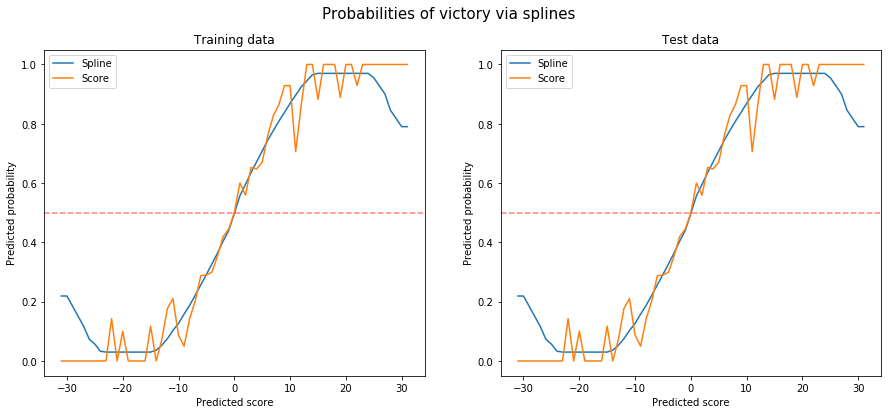

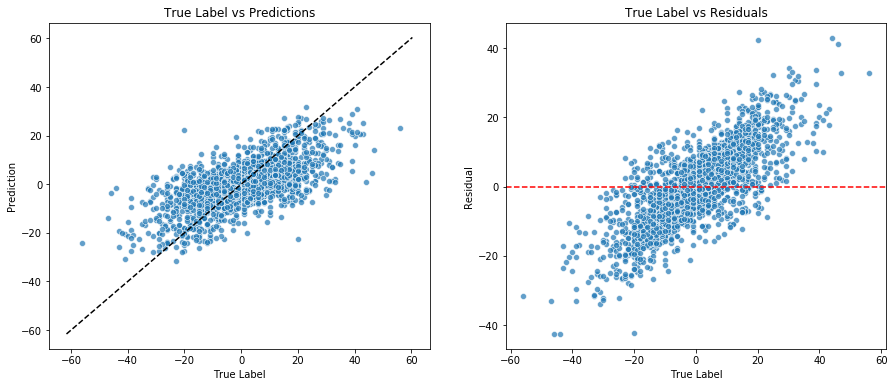

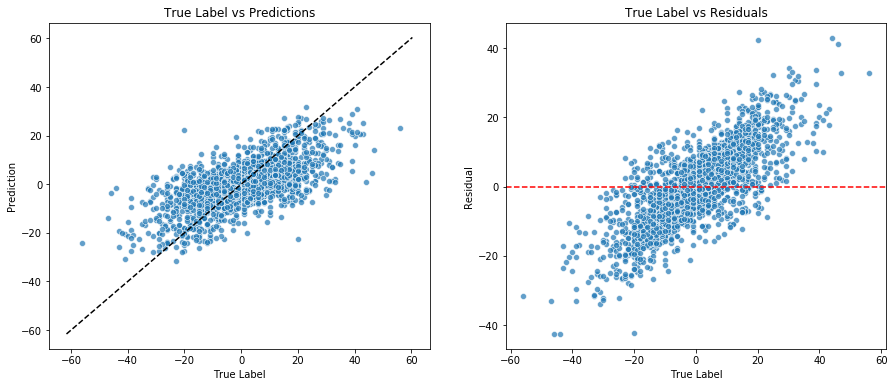

MAE train: 			 8.6455
MAE test: 			 8.6455
RMSE train: 			 11.0777
RMSE test: 			 11.0777
Accuracy train: 		 0.7171
Accuracy test: 			 0.7171
AUC ROC train: 			 0.7171
AUC ROC test: 			 0.7171
Logloss train: 			 0.533
Logloss test: 			 0.533
Unsure train: 			 20.07%
Unsure test: 			 20.07%


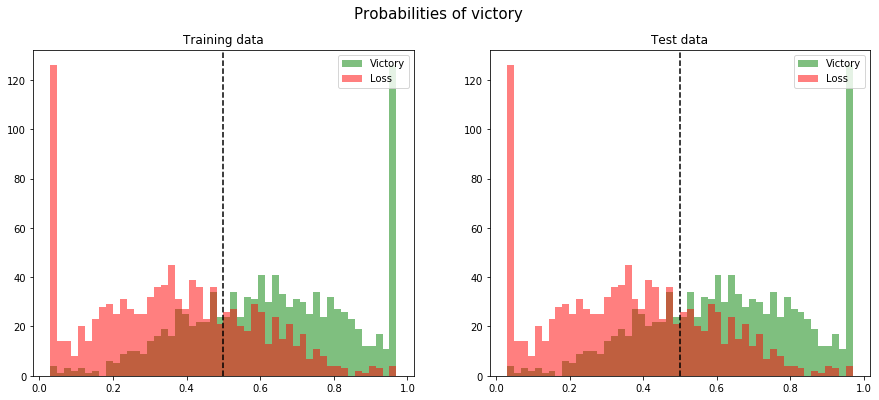

In [18]:
mean_oof = (oof_las + oof_net + oof_ridge + oof_forest + oof_xgb) / 5
rp.report_points(train, train, y_train, y_train, mean_oof, mean_oof, plot=True)

           lasso    forest       xgb
lasso   1.000000  0.975685  0.976558
forest  0.975685  1.000000  0.976533
xgb     0.976558  0.976533  1.000000
1
-8.627332525054731
{'forest__max_depth': 3, 'forest__min_samples_leaf': 8}
2
-8.667019922386816
{'forest__max_depth': 3, 'forest__min_samples_leaf': 8}
3
-8.781838454556965
{'forest__max_depth': 3, 'forest__min_samples_leaf': 1}
4
-8.66225526076659
{'forest__max_depth': 3, 'forest__min_samples_leaf': 1}
5
-8.79915123457277
{'forest__max_depth': 3, 'forest__min_samples_leaf': 2}


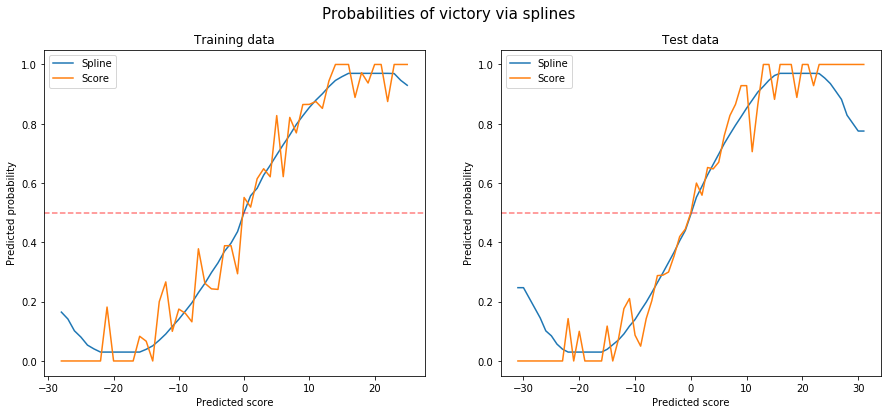

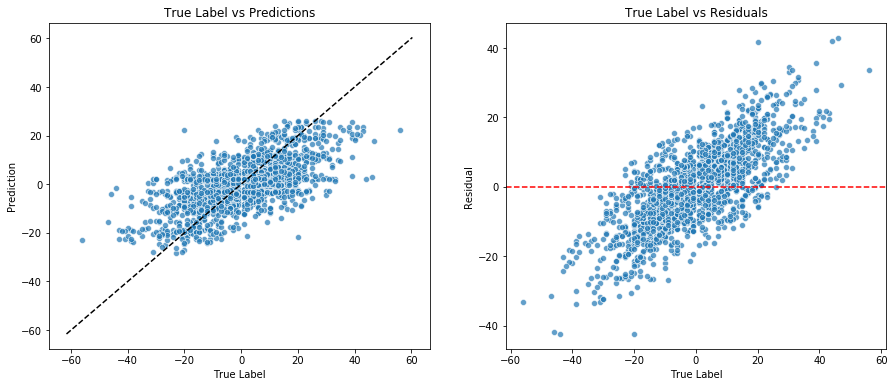

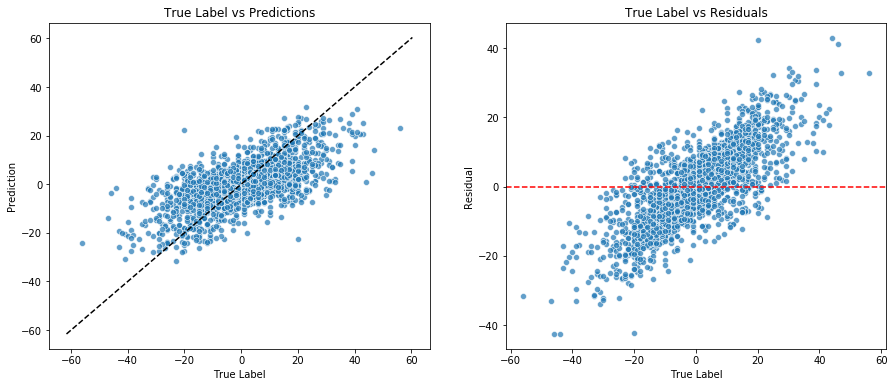

MAE train: 			 8.6857
MAE test: 			 8.6455
RMSE train: 			 11.1247
RMSE test: 			 11.0777
Accuracy train: 		 0.7204
Accuracy test: 			 0.7171
AUC ROC train: 			 0.7204
AUC ROC test: 			 0.7171
Logloss train: 			 0.5327
Logloss test: 			 0.5339
Unsure train: 			 13.17%
Unsure test: 			 20.07%


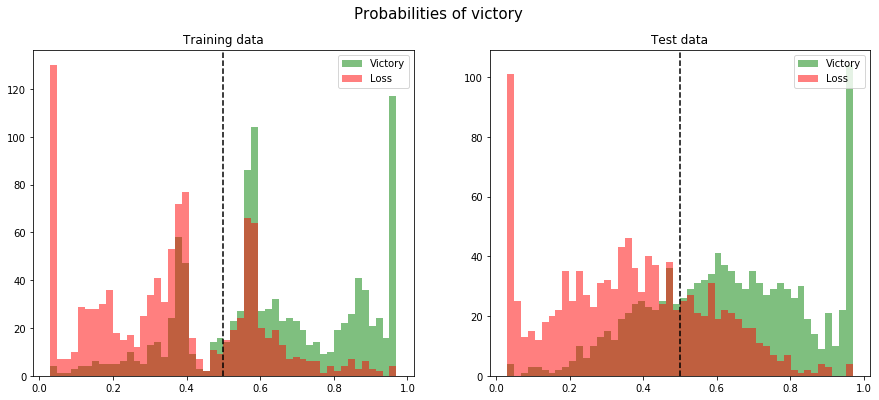

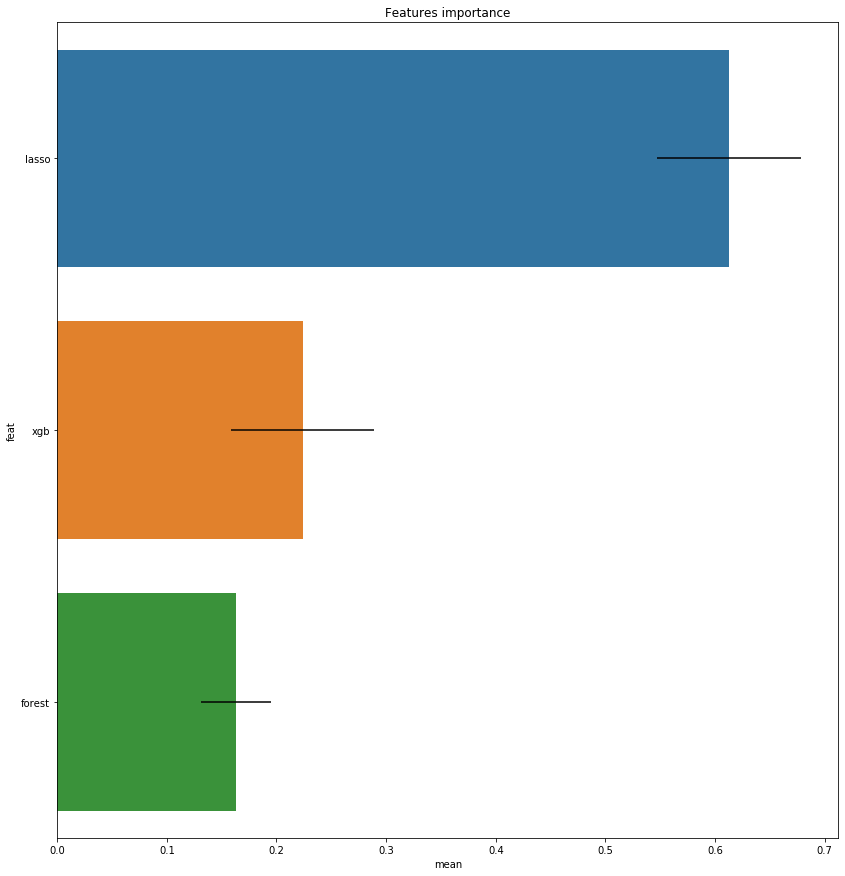

In [23]:
second_level = pd.DataFrame({'lasso': oof_las, 'forest': oof_forest, 'xgb': oof_xgb}) # 'ridge': oof_ridge, 'net': oof_net, 
print(second_level.corr())
second_oof = np.zeros(len(second_level))
feat_df_sec = pd.DataFrame()

grid_param = {'forest__max_depth': [3, 5, 7, 10, 20, None], 
        'forest__min_samples_leaf': [1, 2, 4, 8, 16, 32, 64]}

for n_fold, (train_index, test_index) in enumerate(kfolds.split(second_level.values)):
    print(n_fold+1)

    trn_data = second_level.iloc[train_index][:]
    val_data = second_level.iloc[test_index][:]

    trn_target = y_train.iloc[train_index].values.ravel()
    val_target = y_train.iloc[test_index].values.ravel()

    clf = Pipeline([('feat_eng', feat_eng()), 
                    ('forest', RandomForestRegressor(n_estimators=500, criterion='mse'))])
    
    grid = GridSearchCV(clf, param_grid=grid_param, n_jobs=-1, 
                                cv=5, scoring='neg_mean_absolute_error')
    grid.fit(trn_data, trn_target)
    clf = grid.best_estimator_
    print(grid.best_score_)
    print(grid.best_params_)

    second_oof[test_index] = clf.predict(val_data).ravel()
    
    fold_df = rp.get_feature_importance(clf)
    fold_df['fold'] = n_fold + 1
    feat_df_sec = pd.concat([feat_df_sec, fold_df], axis=0)
    
feat_df_sec = feat_df_sec.groupby('feat')['score'].agg(['mean', 'std'])
feat_df_sec['abs_sco'] = (abs(feat_df_sec['mean']))
feat_df_sec = feat_df_sec.sort_values(by=['abs_sco'],ascending=False)
del feat_df_sec['abs_sco']

rp.report_points(second_level, second_level, y_train, y_train, second_oof, mean_oof, plot=True)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=feat_df_sec.head(50).reset_index(), 
            xerr=feat_df_sec.head(50)['std'])
plt.title(f'Features importance')
plt.show()

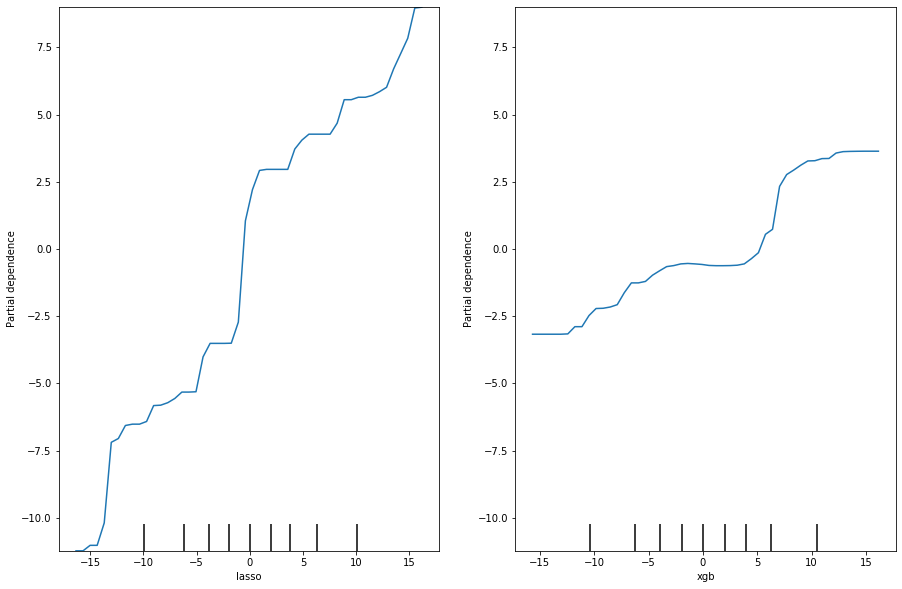

In [24]:
feats = feat_df_sec.head(2).reset_index().feat.values

fig, ax = plt.subplots(1,2, figsize=(15,10))

clf.fit(second_level, y_train)

plot_partial_dependence(clf.steps[-1][1], second_level, feats, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

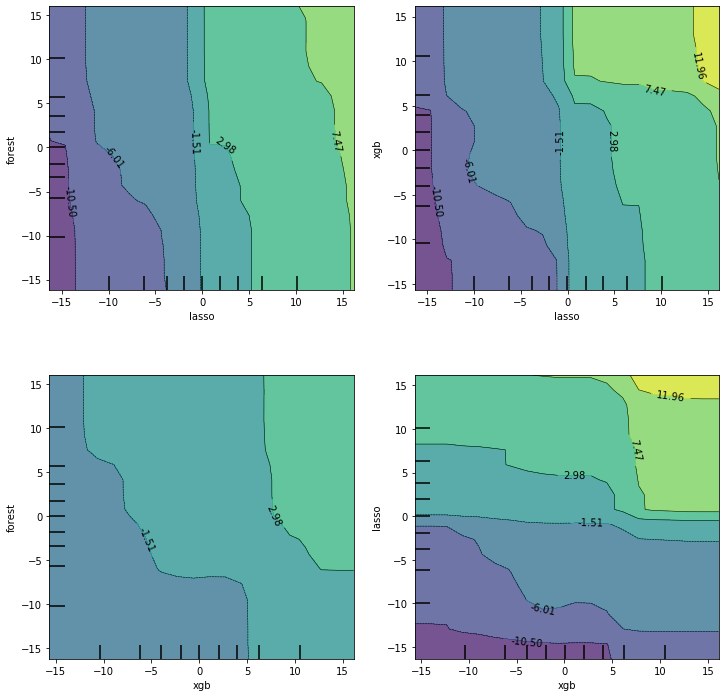

In [25]:
features = [('lasso', 'forest'), ('lasso', 'xgb'), 
            ('xgb', 'forest'), ('xgb', 'lasso')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(clf.steps[-1][1], second_level, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

In [52]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds - labels    
    grad = x / (x**2 / c**2 + 1)
    hess = - c**2 *(x**2 - c**2) / (x**2 + c**2)**2
    return grad, hess

In [53]:
X = df[special_selection].values#.drop(to_drop, axis=1)#.values
y = df['target_points']
#X = feat_eng(lastyr=True).fit_transform(X, y).values
#y = df['target_points']
dtrain = xgb.DMatrix(X, label = y)

param = {}
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

xgb_cv = []
repeat_cv = 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 50,
          verbose_eval = 50
        )
    )
    
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]

print(iteration_counts, val_mae)

oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X, y):
        dtrain_i = xgb.DMatrix(X[train_index], label = preds[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = preds[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))


spline_model = []
val_cv = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i], np.where(y > 0, 1, 0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y > 0, 1, 0),spline_fit)}")
    val_cv.append(pd.DataFrame({"y":np.where(y > 0, 1, 0), 
                                "pred":spline_fit, 
                                "season":df.Season}))
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

Fold repeater 0
[0]	train-mae:11.45883+0.08790	test-mae:11.46197+0.35299
[50]	train-mae:9.03357+0.07518	test-mae:9.22988+0.31952
[100]	train-mae:8.42427+0.07216	test-mae:8.81647+0.30859
[150]	train-mae:8.14846+0.07335	test-mae:8.72571+0.31121
[200]	train-mae:7.94057+0.07256	test-mae:8.69779+0.31227
[250]	train-mae:7.76475+0.07076	test-mae:8.68820+0.31001
[300]	train-mae:7.60147+0.07050	test-mae:8.68546+0.30542
Fold repeater 1
[0]	train-mae:11.45909+0.04704	test-mae:11.46172+0.18865
[50]	train-mae:9.02952+0.04532	test-mae:9.22239+0.16350
[100]	train-mae:8.41917+0.03474	test-mae:8.81027+0.15764
[150]	train-mae:8.14530+0.02819	test-mae:8.71964+0.15069
[200]	train-mae:7.94329+0.02467	test-mae:8.69043+0.14526
[250]	train-mae:7.76790+0.02387	test-mae:8.67499+0.14461
[300]	train-mae:7.60820+0.02663	test-mae:8.66592+0.14048
[350]	train-mae:7.45784+0.02811	test-mae:8.66045+0.14172
[400]	train-mae:7.31190+0.02788	test-mae:8.66072+0.14298
Fold repeater 2
[0]	train-mae:11.45948+0.09940	test-mae:11

season
2003    0.535845
2004    0.527699
2005    0.507437
2006    0.549156
2007    0.437317
2008    0.466764
2009    0.476931
2010    0.534777
2011    0.619124
2012    0.559106
2013    0.585805
2014    0.574467
2015    0.500835
2016    0.555708
2017    0.486864
2018    0.583555
2019    0.470486
dtype: float64

In [ ]:
2003    0.552234
2004    0.525108
2005    0.485934
2006    0.547957
2007    0.445689
2008    0.453282
2009    0.475051
2010    0.541450
2011    0.616398
2012    0.549479
2013    0.575796
2014    0.571346
2015    0.503469
2016    0.556010
2017    0.492031
2018    0.594353
2019    0.478379

In [ ]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('forest', RandomForestRegressor(n_estimators=500, 
                                                                                max_features='sqrt',
                                                                                n_jobs=5))])

df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc', 'T1_N_wins', 'T2_N_wins', 'delta_N_wins'], axis=1)

grid = {'forest__max_depth': [3, 10, None], 
        'forest__min_samples_split': [16, 32, 64], 
        'forest__min_samples_leaf': [1, 2, 4, 8, 16],
        'feat_sel__k': [5, 10 , 20, 50, 100], 
        'feat_eng__seed': [True, False]}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target_points', tune=True, param_grid=grid)

rp.yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef['2019'].head(50).reset_index(), 
            xerr=imp_coef['2019'].head(50)['std'])
plt.show()

-0.5563966200509951
{'feat_sel__k': 10, 'forest__max_depth': 10, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 2}
-0.5510874225572855
{'feat_sel__k': 10, 'forest__max_depth': 10, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 4}
-0.5571143529455641
{'feat_sel__k': 10, 'forest__max_depth': None, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 16}
-0.5482670717696332
{'feat_sel__k': 10, 'forest__max_depth': 10, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 2}
-0.5574267248136086
{'feat_sel__k': 10, 'forest__max_depth': 10, 'forest__min_samples_leaf': 16, 'forest__min_samples_split': 32}
2015


Accuracy train: 		 0.6861
Accuracy test: 			 0.7761
AUC ROC train: 			 0.6861
AUC ROC test: 			 0.7761
Logloss train: 			 0.5606
Logloss test: 			 0.5382
Unsure train: 			 31.3454%
Unsure test: 			 36.5672%


________________________________________


2016


Accuracy train: 		 0.6775
Accuracy test: 			 0.6791
AUC ROC train: 			 0.6775
AUC ROC

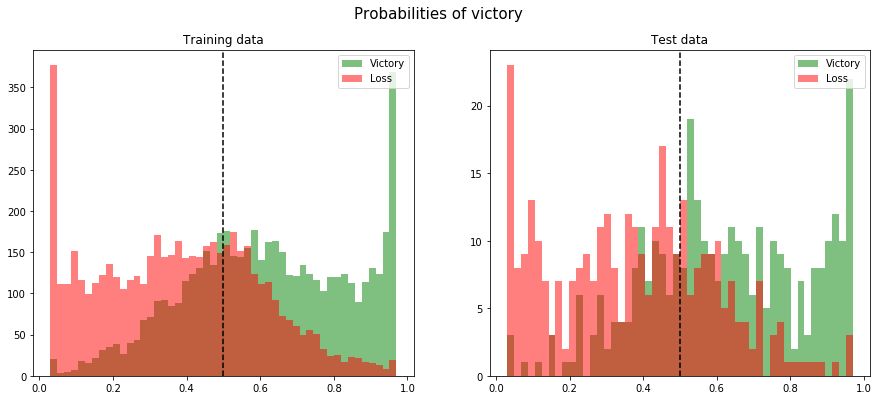

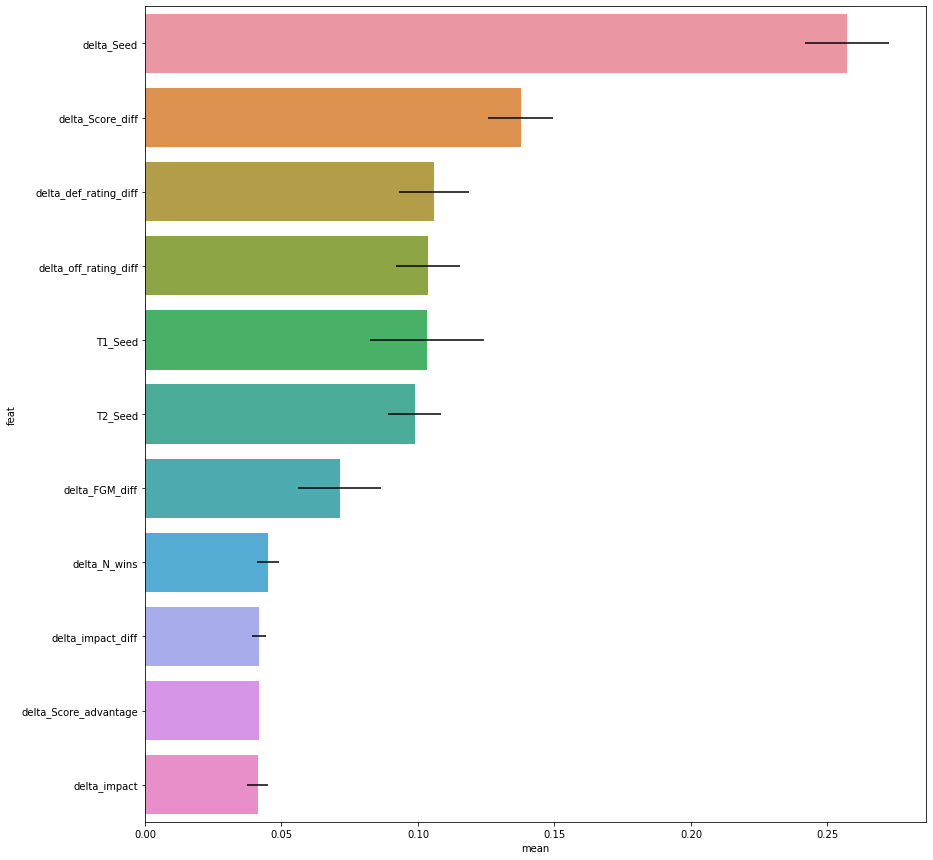

In [14]:
pipe = Pipeline([('feat_eng', feat_eng()), 
                 ('scl', df_p.df_scaler()),
                 ('feat_sel', df_p.selector(mode='reg'))] + [('forest', RandomForestClassifier(n_estimators=500, 
                                                                                max_features='sqrt',
                                                                                n_jobs=5))])

df_train = df[standard + tot].drop(['T1_Loc', 'T2_Loc', 'delta_Loc', 'T1_N_wins', 'T2_N_wins', 'delta_N_wins'], axis=1)

grid = {'forest__max_depth': [3, 10, None], 
        'forest__min_samples_split': [16, 32, 64], 
        'forest__min_samples_leaf': [1, 2, 4, 8, 16],
        'feat_sel__k': [5, 10 , 20, 50, 100], 
        'feat_eng__seed': [True, False]}


fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = yearly_split(df_train, pipe, kfolds, 'target', 
                                                                                   predict_proba=True, tune=True, param_grid=grid)

rp.yearly_wrapper(train, test, y_train, y_test, oof_pred, test_pred, points=False)

plt.figure(figsize=(14, 15))
sns.barplot(x="mean", y="feat", 
            data=imp_coef['2019'].head(50).reset_index(), 
            xerr=imp_coef['2019'].head(50)['std'])
plt.show()

In [4]:
standard = ['Season', 'target', 'target_points', 'ID']

l2w = [col for col in df if 'L2W' in col and col not in standard]
tot = [col for col in df if 'L2W' not in col and col not in standard]
l2w_deltas = [col for col in df if 'L2W' in col and col not in standard and 'delta' in col]
tot_deltas = [col for col in df if 'L2W' not in col and col not in standard and 'delta' in col]

feat_dict = {'l2w': l2w, 'tot': tot, 'l2w_delta': l2w_deltas, 'tot_delta': tot_deltas}

models = [('lasso', Lasso(alpha=0.1)), 
          ('ridge', Ridge()), 
          ('forest', RandomForestRegressor(n_estimators=200, n_jobs=5)), ('xtree', ExtraTreesRegressor(n_estimators=200, n_jobs=5)), 
          ('xgb', XGBRegressor(n_estimators=100))]

for model in models:
    print('_'*40)
    print(model[0])
    for feats in feat_dict.keys():
        print(f'\t {feats}')
        print('\t'+'-'*30)
        df_train = df[standard + feat_dict[feats]]
        
        pipe = Pipeline([('scl', df_p.df_scaler())] + [model])
        
        fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')
        
        rp.report_points(train, test, y_train, y_test, oof_pred, test_pred, plot=False)
        print('\t'+'-'*30)
    print('_'*40)

________________________________________
lasso
	 l2w
	------------------------------
MAE train: 			 11.0385
MAE test: 			 11.1105
RMSE train: 			 13.806
RMSE test: 			 13.9454
Accuracy train: 		 0.5858
Accuracy test: 			 0.5583
Logloss train: 			 0.6723
Logloss test: 			 0.6912
Unsure train: 			 17.43%
Unsure test: 			 19.06%
	------------------------------
	 tot
	------------------------------
MAE train: 			 8.8011
MAE test: 			 8.8945
RMSE train: 			 11.2828
RMSE test: 			 11.173
Accuracy train: 		 0.7158
Accuracy test: 			 0.6951
Logloss train: 			 0.5377
Logloss test: 			 0.5456
Unsure train: 			 9.87%
Unsure test: 			 10.09%
	------------------------------
	 l2w_delta
	------------------------------
MAE train: 			 10.9449
MAE test: 			 11.0228
RMSE train: 			 13.6988
RMSE test: 			 13.8453
Accuracy train: 		 0.5975
Accuracy test: 			 0.5785
Logloss train: 			 0.6677
Logloss test: 			 0.689
Unsure train: 			 17.94%
Unsure test: 			 18.16%
	------------------------------
	 tot_delta

In [ ]:
param_grid = {#'xgb__n_estimators': np.arange(20, 500, 20), 
              'xgb__learning_rate': np.arange(0.01, 0.8, 0.01), 
              'xgb__max_depth': np.arange(1, 15, 1), 
              'xgb__gamma': np.arange(0.01, 1, 0.01)}

pipe = Pipeline([('scl', df_p.df_scaler())] + [('xgb', XGBRegressor(n_estimators=100, n_jobs=5))])

df_train = df[tot_deltas]
y_train = df['target_points']

res, bp, _ = ut.grid_search(df_train, y_train, pipe, param_grid, 'neg_mean_absolute_error', kfolds, random=1)

res.head(10)

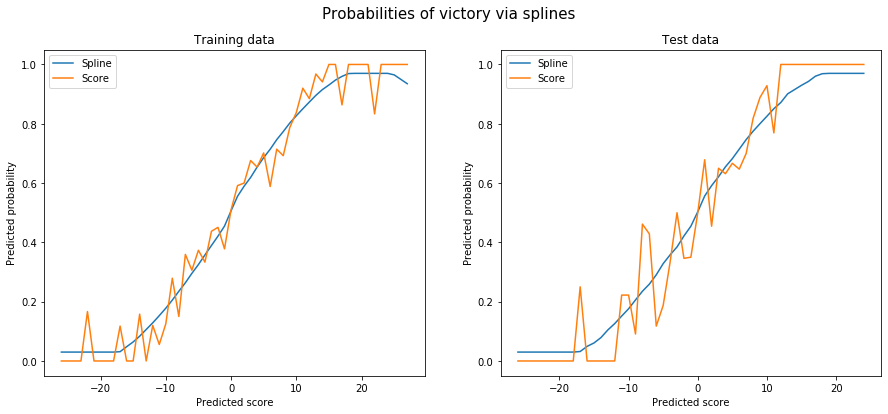

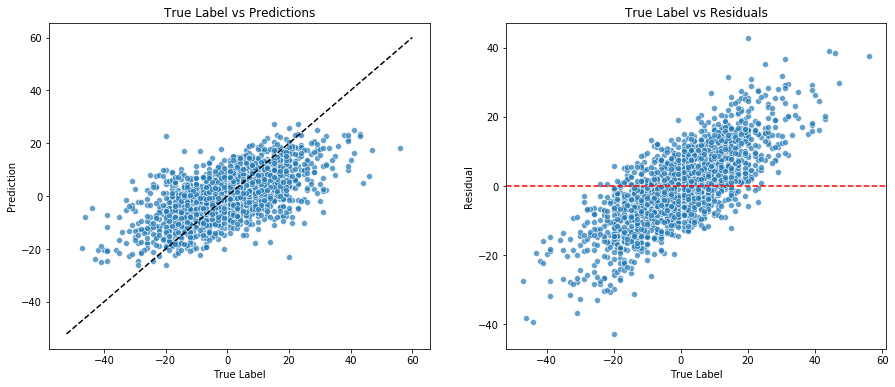

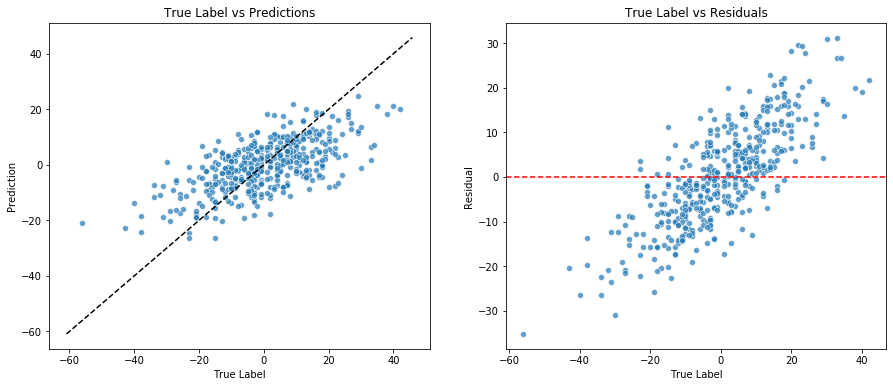

MAE train: 			 8.745
MAE test: 			 8.7866
RMSE train: 			 11.1988
RMSE test: 			 11.0573
Accuracy train: 		 0.7231
Accuracy test: 			 0.7242
Logloss train: 			 0.5365
Logloss test: 			 0.5393
Unsure train: 			 8.8%
Unsure test: 			 7.17%


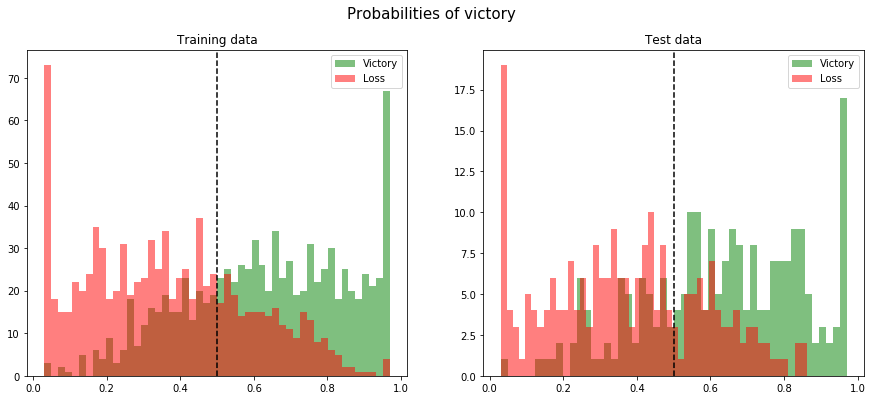

In [4]:
pipe = Pipeline([('scl', df_p.df_scaler()), ('ridge', Ridge())])

fitted, oof_pred, test_pred, imp_coef, train, y_train, test, y_test = random_split(df_train, pipe, kfolds, 'target_points')

rp.report_points(train, test, y_train, y_test, oof_pred, test_pred)